# Lecture 17 - Uncertainty Propagation: Polynomial Chaos II

## Objectives

+ Introduce quadrature rules in 1D and in particular nested quadrature rules.
+ Expand quadrature rules in multiple dimensions using sparse grids.

## Readings

+ These notes.
+ Sullivan, Chapter 9.


In [1]:
import numpy as np
import math
import scipy.stats as st
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')
import design
import warnings
warnings.filterwarnings('ignore')
import orthpol  # This is the package we will use to construct orthogonal polynomials

## Quadrature Rules

### Simple Quadrature
Consider the problem of evaluating an integral:
$$
I = \int_a^b f(x) dx,
$$
where $a < b$.
A *quadrature rule* is an approximation to that integral of the form:
$$
Q(f) = \sum_{k=1}^nw_kf(x_k).
$$
The $x_k$'s are the *nodes* of the rule and the $w_k$'s are the *weights* of the rule.

### Newton-Cotes rule (don't use it)
Let's introduce this one by one.
This rule is constructed as follows:

+ Pick equidistant points in $[a,b]$:
$$
x_k = a + h k,
$$
for $k=0,\dots,n+1$, where $h = \frac{b-a}{n+1}$.

+ Approximate $f$ using the [Lagrange polynomials](https://en.wikipedia.org/wiki/Lagrange_polynomial):
$$
f(x) \approx \sum_{k=1}^n f(x_k)\ell_k(x).
$$

+ Approximate the integral by:
$$
Q_{nc}(f) = \sum_{k=1}^n \int_a^b\ell_k(x)dx \cdot f(x_k),
$$
i.e.,
$$
w_k = \int_a^b\ell_k(x)dx.
$$

In other words, the Newton-Cotes rule approximate the integral with the integral of the Lagrange polynomial that approximates the function based on these points.

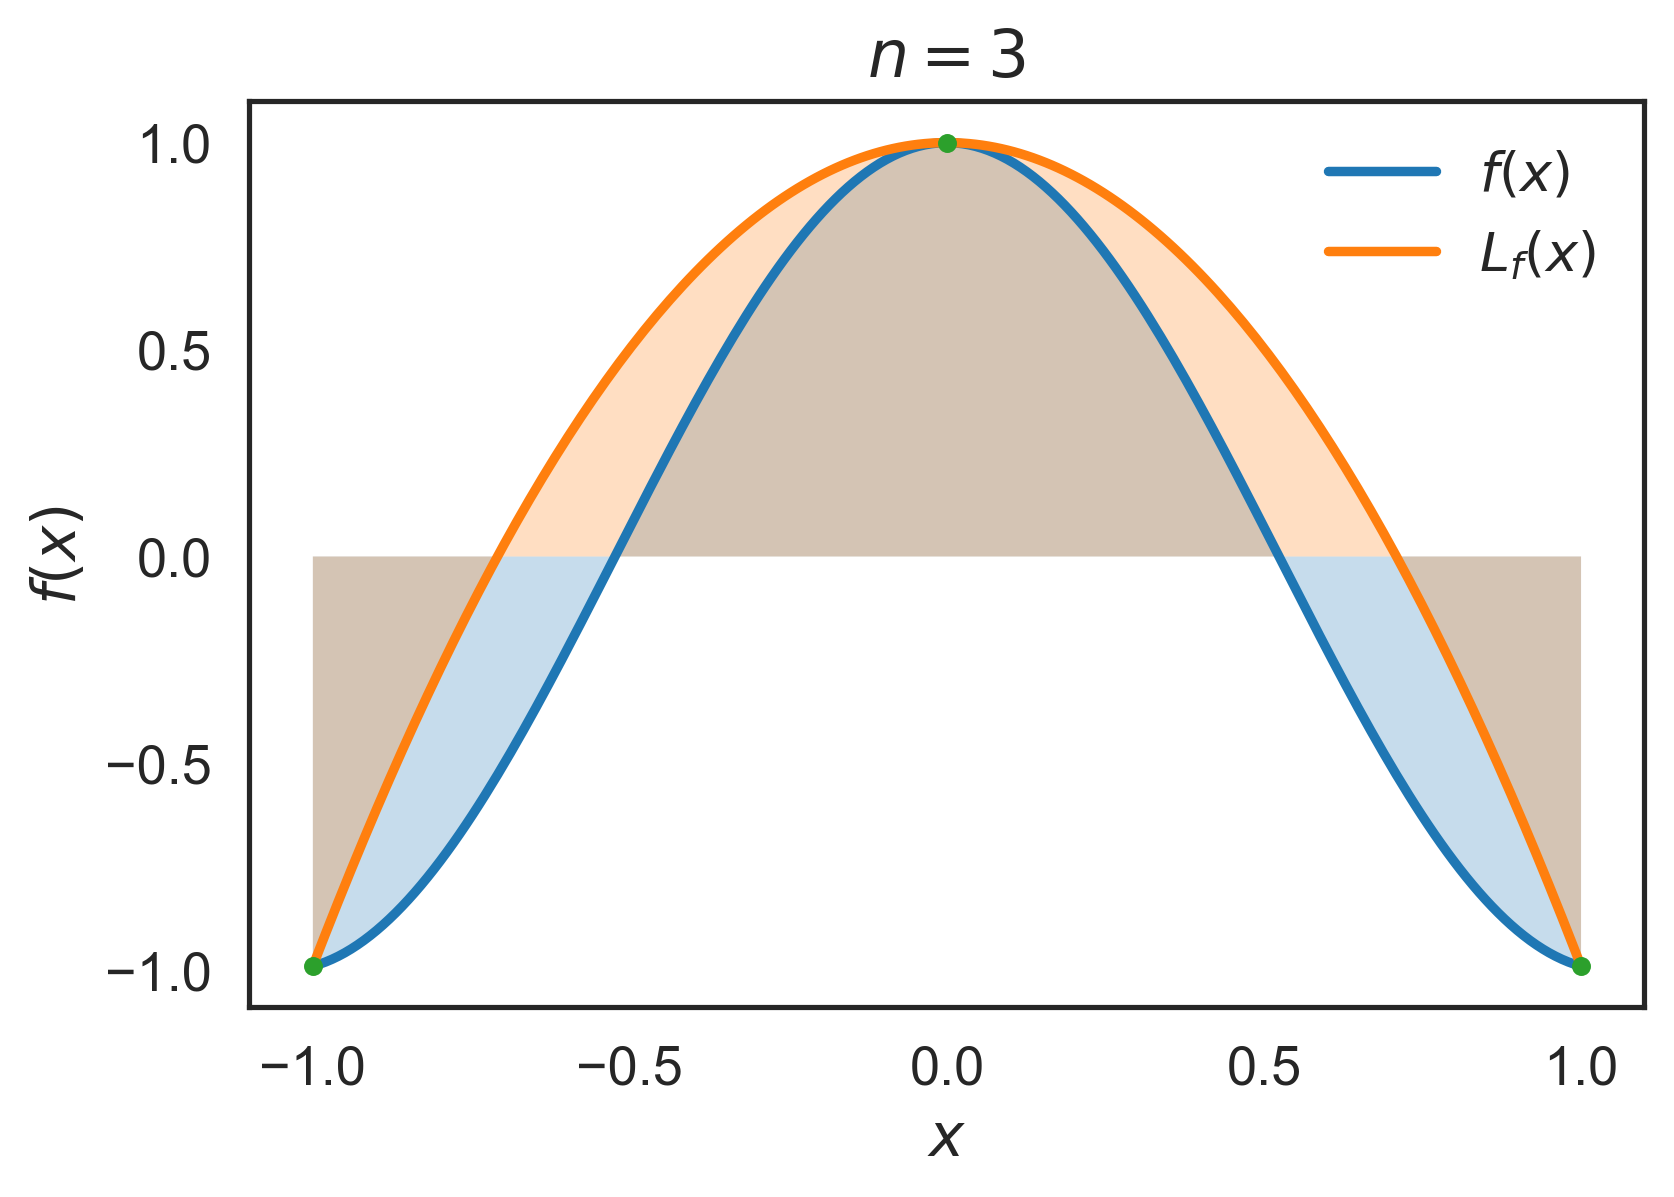

In [2]:
# The function we will integrate
f = lambda x: np.cos(x * 3)

# Pick Newton-Cotes quadrature points
nq = 3
X = np.linspace(-1, 1, nq)

# Get the Lagrange interpolating polynomial
Lf = scipy.interpolate.lagrange(X, f(X))

# Visualize the actual function and the Lagrange interpolating polynomial
fig, ax = plt.subplots()
x = np.linspace(-1, 1, 200)

ax.plot(x, f(x))
ax.fill_between(x, np.zeros(x.shape), f(x), alpha=0.25)
ax.plot(x, Lf(x))
ax.fill_between(x, np.zeros(x.shape), Lf(x), alpha=0.25)
ax.plot(X, f(X), '.')
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')
ax.set_title('$n=%d$' % nq)
plt.legend(['$f(x)$', '$L_f(x)$'], loc='best');

### Questions

+ Change the function above to $f(x) = H(x)$ (step function) and see that the Newton-Cotes rule has trouble approximating the integral no matter how many quadrature points you use.

### Gaussian quadrature (don't use it)

This is just like the Newton-Cotes rule, but instead of equidistant nodes it uses nodes that are the zeros of the $n$-degree orthogonal polynomial with weight $w(x) = 1$.

**Note:** You can generalize the Gaussian quadrature rule, for other weights.

**Note:** Gaussian quadrature integrates exactly polynomials up to degree $2n + 1$ and there is no other quadrature rule with $n$ points that can do that.

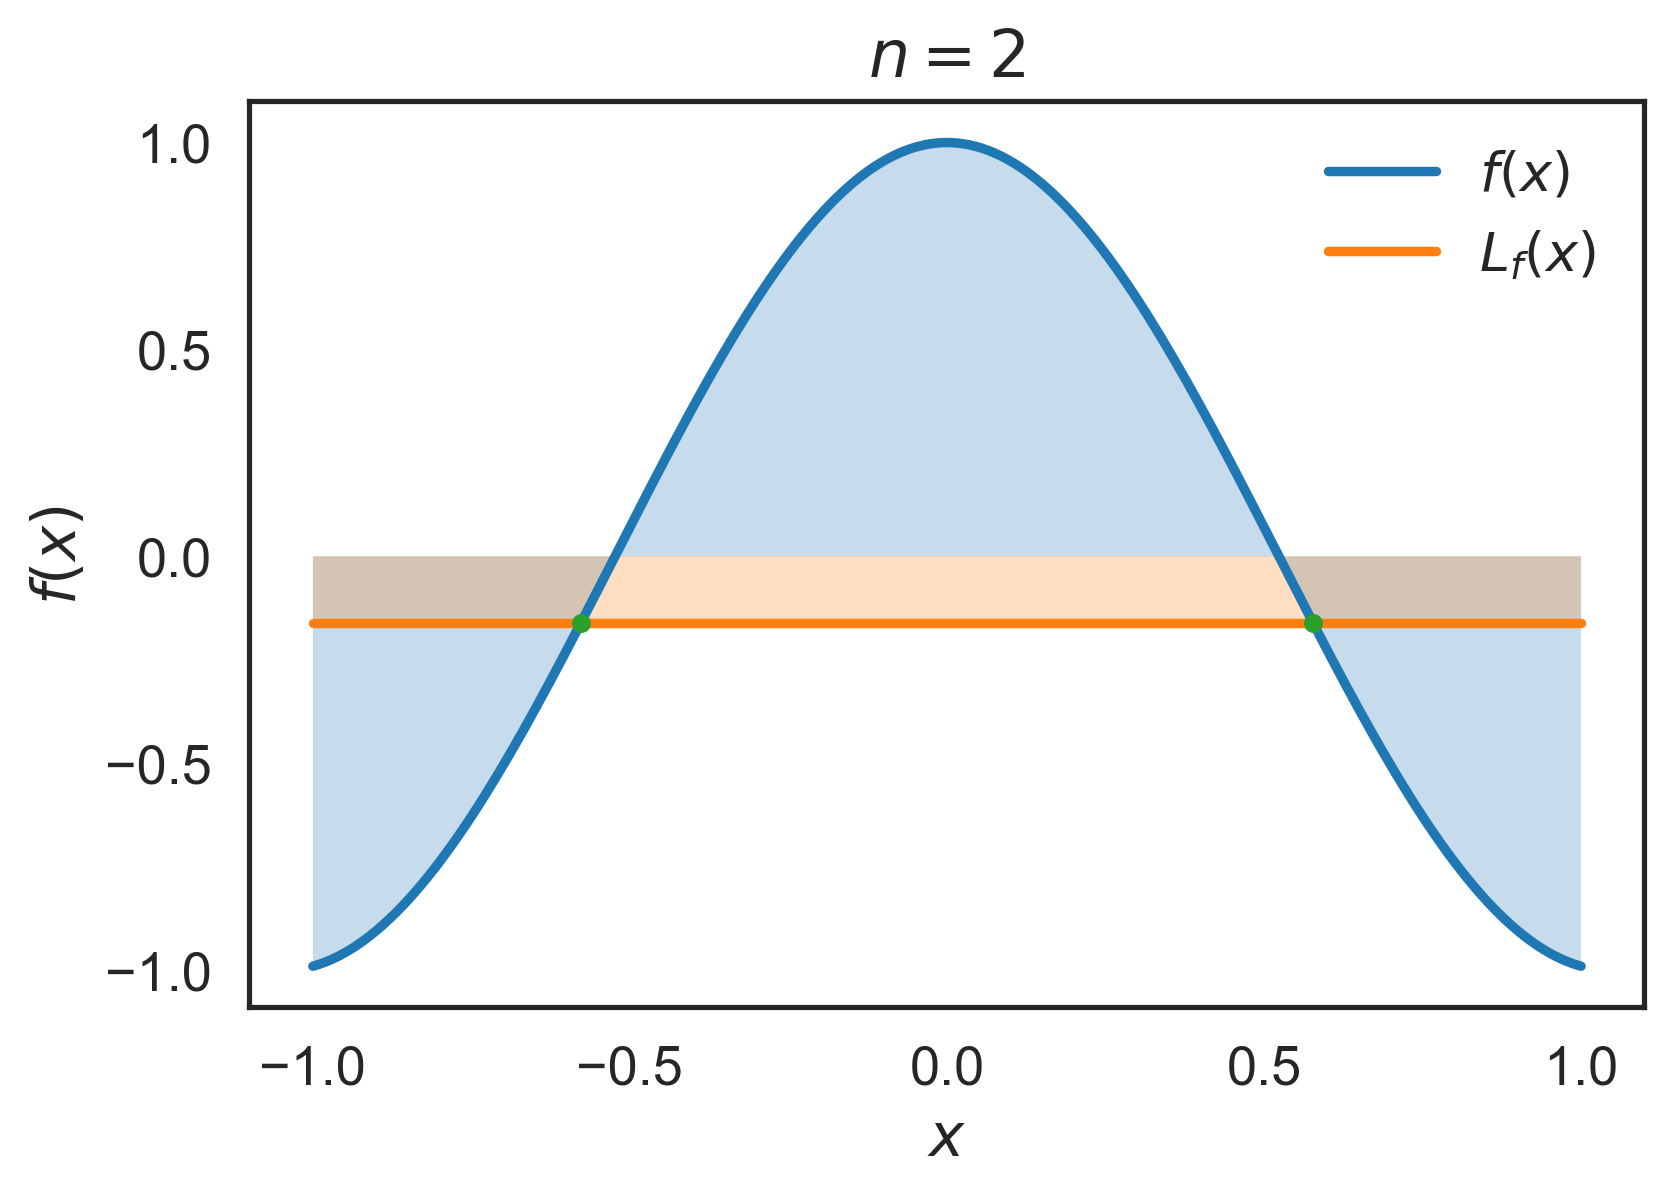

In [3]:
# The function we will integrate
f = lambda x: np.cos(x * 3)


# Pick Newton-Cotes quadrature points
nq = 2
# Get the roots of the nq - 1 degree polynomial with w[x] = 1 in [-1, 1] (Legendre)
Xs, ws = scipy.special.roots_legendre(nq-1)
# Get the roots of the nq degree polynomial
X, w = scipy.special.roots_legendre(nq)

# Get the Lagrange interpolating polynomial
Lf = scipy.interpolate.lagrange(X, f(X))

# Visualize the actual function and the Lagrange interpolating polynomial
fig, ax = plt.subplots()
x = np.linspace(-1, 1, 200)

ax.plot(x, f(x))
ax.fill_between(x, np.zeros(x.shape), f(x), alpha=0.25)
ax.plot(x, Lf(x))
ax.fill_between(x, np.zeros(x.shape), Lf(x), alpha=0.25)
ax.plot(X, f(X), '.')
#ax.plot(Xs, f(Xs), '.')
ax.set_xlabel('$x$')
ax.set_title('$n=%d$' % nq)
ax.set_ylabel('$f(x)$')
plt.legend(['$f(x)$', '$L_f(x)$'], loc='best');

### Questions

+ Notice that the Gaussian quadrature nodes are not nested. Every time you increase the number of quadrature points, you get completely different nodes. This means that you cannot reuse the function evaluations you have seen so far.
+ Change the function above to $f(x) = H(x)$ (step function) and see that the Gaussian quadrature rule has less trouble approximating the integral no matter how many quadrature points you use.
+ Try $f(x) = \cos(10 x) * \exp\{-(10x)^2/2\}$ to see that some problems do persist.

### Clenshaw-Curtis Quadrature

We are looking for a quadrature rule with nested nodes. As we increase the number of points, we would like to be able to reuse the function evaluations.

The derivation is quite involved, but it goes like this.
Let us look at the case $a=-1, b=1$.
First, we transform the integral by setting $x = \cos\theta$:
$$
\int_{-1}^1 f(x)dx = \int_0^\pi f(\cos\theta)\sin(\theta)d\theta.
$$
Then, expand the $f(\cos\theta)$ in cosine series:
$$
f(\cos\theta) = \frac{a_0}{2} + \sum_{k=1}^\infty a_k \cos(k\theta),
$$
where
$$
a_k = \frac{2}{\pi}\int_0^\pi f(\cos\theta)\cos(k\theta)d\theta.
$$
From this, we get:
$$
\int_0^\pi f(\cos\theta)\sin\theta d\theta = a_0 + \sum_{k=1}^\infty\frac{2a_k}{1 - (2k)^2}.
$$
Now, using the [Nyquist-Shannon sampling theorem](https://en.wikipedia.org/wiki/Nyquist–Shannon_sampling_theorem) from signal processing, we see that we can evaluate the coefficients $a_k$ for $k\le n$ **exactly** if we evaluate $f(\cos\theta)$ at $n+1$ equidistant nodes $\theta_j = \frac{j\pi}{n}, j=0,\dots,n$. It is:
$$
a_k = \frac{2}{n}\left((-1)^k\frac{f(-1)}{2} + \frac{f(1)}{2} + \sum_{j=1}^{n-1}f\left(\cos\frac{j\pi}{n}\right)\cos\frac{kj\pi}{n}\right).
$$
So, we see that the nodes are:
$$
x_j = \cos\frac{j\pi}{n},
$$
$j=0,1,\dots,n$ and that they are indeed nested (double $n$).
To get the weigths, you re-arrange terms and you try to identify the $w_j$'s.

**Note:** Clenshaw-Curtis quadrature integrates exactly polynomials up to degree $n+1$.

**Note:** We will only be using the Clenshaw-Curtis quadrature from now on.

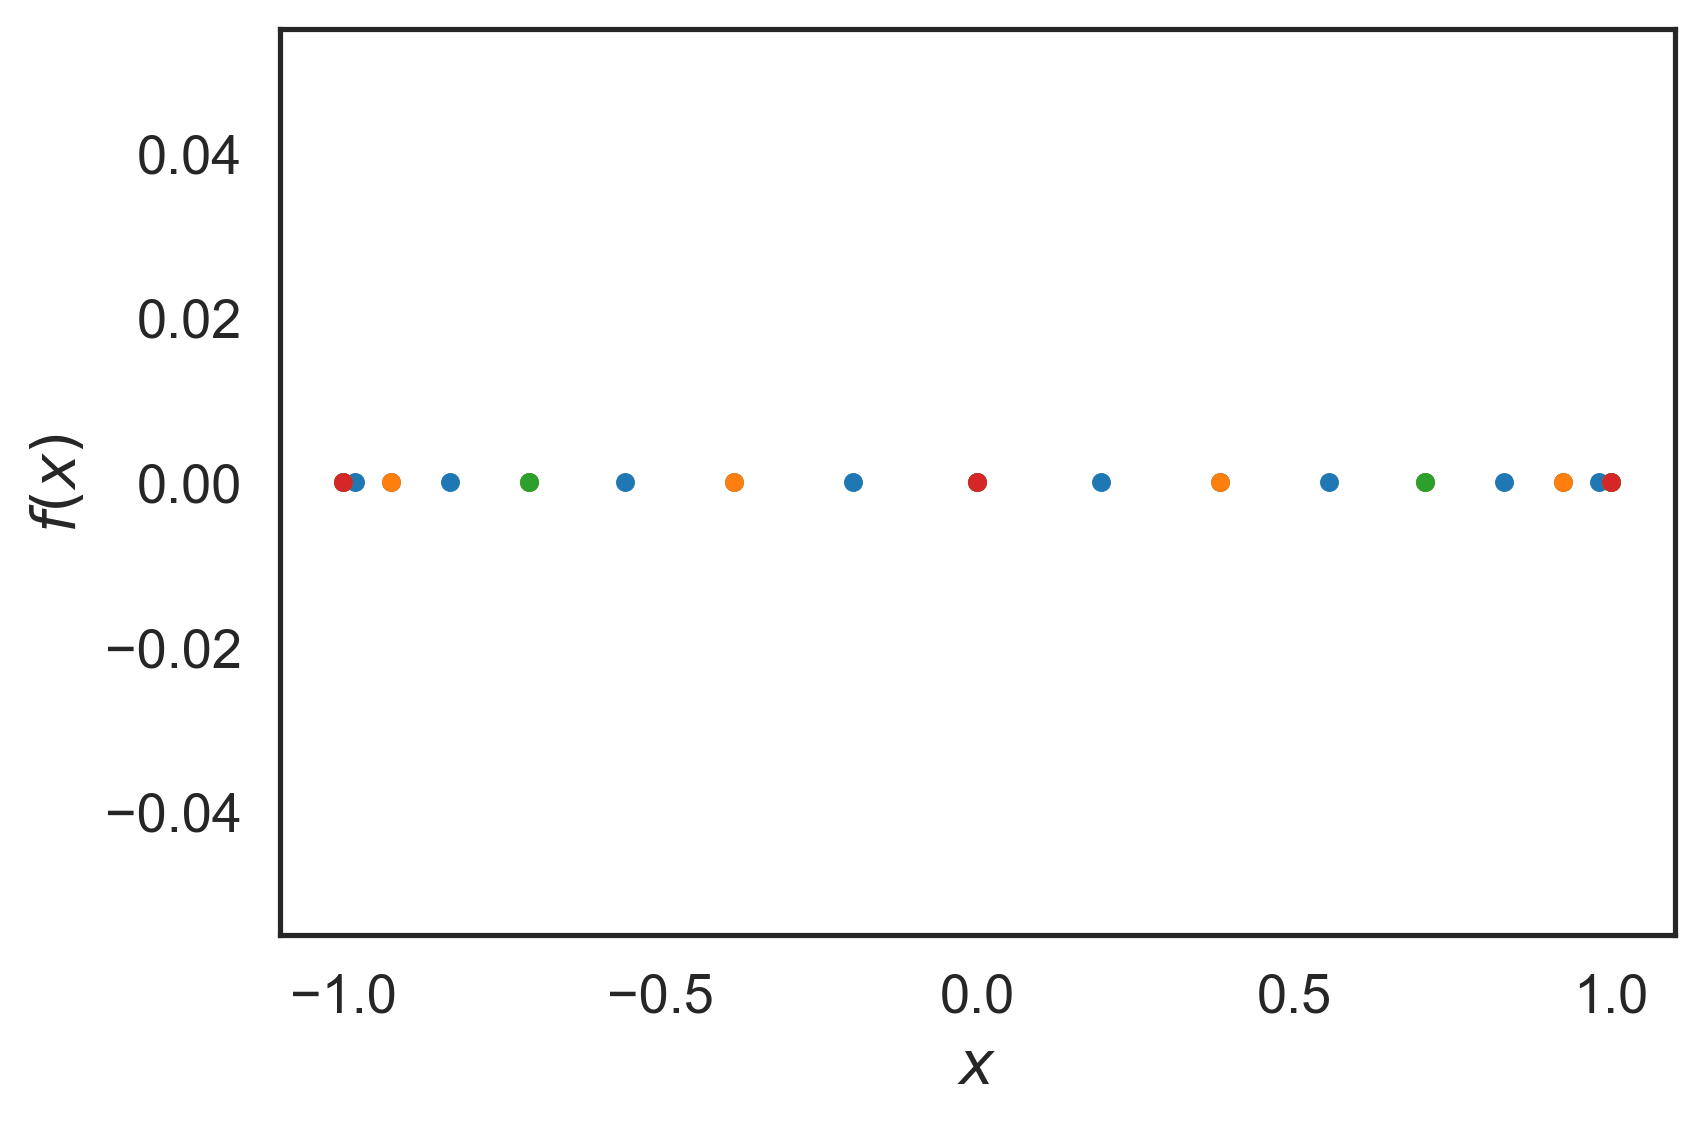

In [4]:
# The function we will integrate
#f = lambda x: np.cos(x * 5)

# Pick Newton-Cotes quadrature points
fig, ax = plt.subplots()
for l in [4, 3, 2, 1]:
    X, w = design.sparse_grid(1, l, rule='CC') # CC = Clenshaw-Curtis
    ax.plot(X, np.zeros(X.shape[0]), '.')
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')

### Example: Verify that the Legendre Polynomials are Orthogonal

Let $X\sim\mathcal{U}(-1, 1)$. The orthogonal polynomials in this case are known as the [Laguerre polynomials](https://en.wikipedia.org/wiki/Laguerre_polynomials).
They are known analytically.
The first few are:
$$
\begin{array}{ccc}
\phi_1(x) &=& 1,\\
\phi_2(x) &=& x,\\
\phi_3(x) &=& \frac{1}{2}\left(3x^2 -1\right).
\end{array}
$$

We constructed them we ``orthpol`` in the previous handout.
Let's verify now that they are also orthogonal by using a CC quadrature rule.

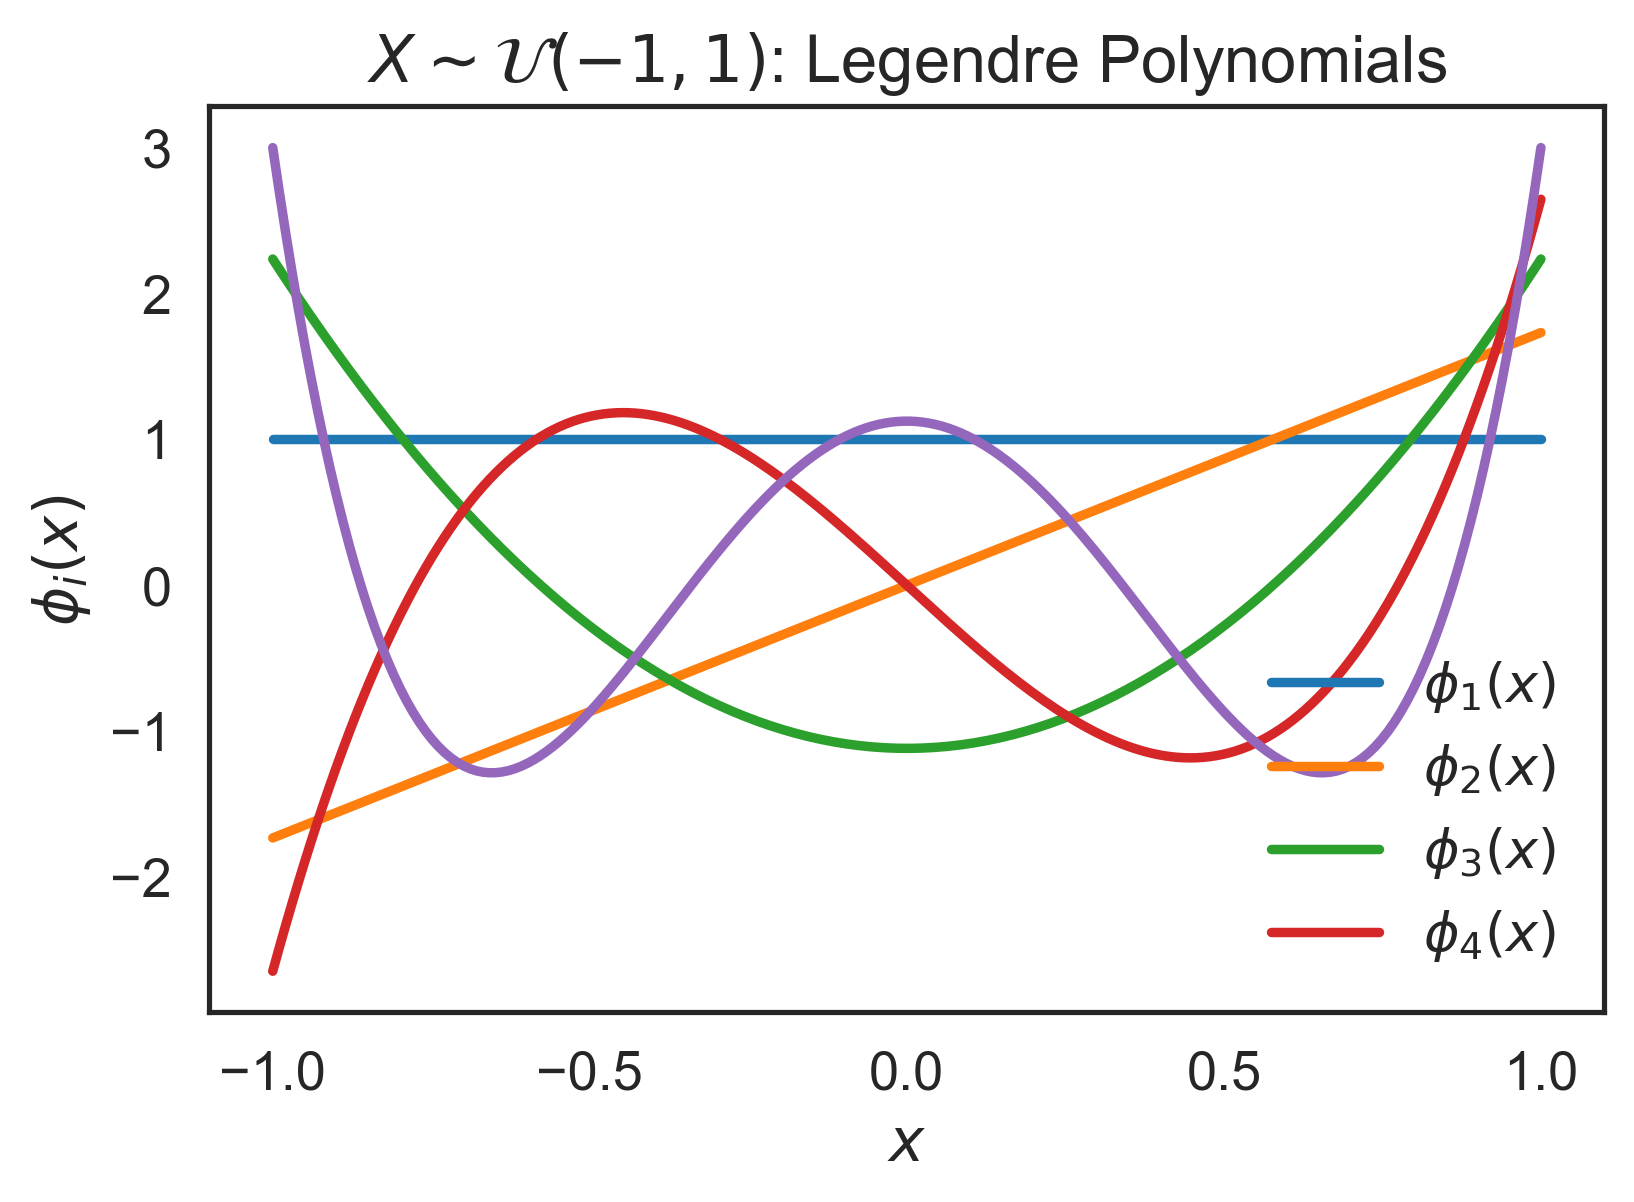

In [5]:
# Now, instead of the random variable let's use the the p(x) derectly
p = lambda x: 0.5
# The maximum polynomial degree you want
degree = 4
# Construct the orthogonal polynomials
Phi_set = orthpol.OrthogonalPolynomial(degree,
                                       wf=p,    # The weight function (or pdf)
                                       left=-1, # The left bound
                                       right=1  # The right bound
                                       )

# Plot them
fig, ax = plt.subplots()
# Evaluate the orhtogonal polynomials on all these x's
x = np.linspace(-1, 1, 200)
phi_x = Phi_set(x)    # 200 x (degree + 1)
# Plot each one of them
ax.plot(x, phi_x);
ax.set_xlabel('$x$')
ax.set_ylabel('$\phi_i(x)$')
ax.set_title('$X\sim\mathcal{U}(-1, 1)$: Legendre Polynomials')
plt.legend(['$\phi_{%d}(x)$' % i for i in range(1, degree + 1)], loc='best');

In [6]:
X, w = design.sparse_grid(1, 5, 'CC') # w(x) = 1 and x in [-1, 1] for this one
w = w / 2.  # We need to normalize the weights
phi_q = Phi_set(X)
for i in range(phi_q.shape[1]):
    for j in range(i, phi_q.shape[1]):
        print '<%d, %d> \t= %1.3f' % (i, j, np.sum(w * phi_q[:, i] * phi_q[:, j]))

<0, 0> 	= 1.000
<0, 1> 	= 0.000
<0, 2> 	= -0.000
<0, 3> 	= 0.000
<0, 4> 	= 0.000
<1, 1> 	= 1.000
<1, 2> 	= 0.000
<1, 3> 	= 0.000
<1, 4> 	= 0.000
<2, 2> 	= 1.000
<2, 3> 	= 0.000
<2, 4> 	= 0.000
<3, 3> 	= 1.000
<3, 4> 	= 0.000
<4, 4> 	= 1.000


### Evaluating Arbitrary Expecations with the CC Quadrature Rule

The CC rule can only evaluate integrals of the form $\int_{-1}^1f(x)dx$.
Let's see how we can extend it to the evaluation of arbitrary expectations of the form:
$$
\mathbb{E}[f(X)]:=\int_{-\infty}^\infty f(x)p(x)dx.
$$
Let $F(x)$ be the CDF of $p(x)$ and define the transformation:
$$
z = 2F(x) - 1.
$$
The inverse, of course, is:
$$
x = F^{-1}\left(\frac{z+1}{2}\right).
$$
Notice that $z\in [-1,1]$.
We also have that:
$$
dz = 2F'(x)dx = 2p(x)dx
$$
and that as $x\rightarrow \pm \infty$ we get that $z\rightarrow\pm 1$.
Therefore, we can rewrite the expcation as:
$$
\mathbb{E}[f(X)] = \frac{1}{2}\int_{-1}^1 f\left(F^{-1}\left(\frac{z+1}{2}\right)\right)dz
$$
Now, if $z_k$ and $v_k$, $k=1,\dots,n$ are nodes and weights for the common CC rule, we get the following quadrature rule for our special case:
$$
w_k = \frac{1}{2}v_k,
$$
and
$$
x_k = F^{-1}\left(\frac{z_k+1}{2}\right).
$$

Let's try it out by testing the Hermite polynomials.

### Example 1: The Standard Normal and the Hermite Polynomials

Let $X\sim\mathcal{N}(0,1)$. The orthogonal polynomials in this case are known as the [Hermite polynomials](https://en.wikipedia.org/wiki/Hermite_polynomials).
They are known analytically.
The first few are:
$$
\begin{array}{ccc}
\phi_1(x) &=& 1,\\
\phi_2(x) &=& x,\\
\phi_3(x) &=& x^2 - 1,\\
\phi_4(x) &=& x^3 - 3x,\\
\phi_5(x) &=& x^4 - 6x^2 + 3.
\end{array}
$$

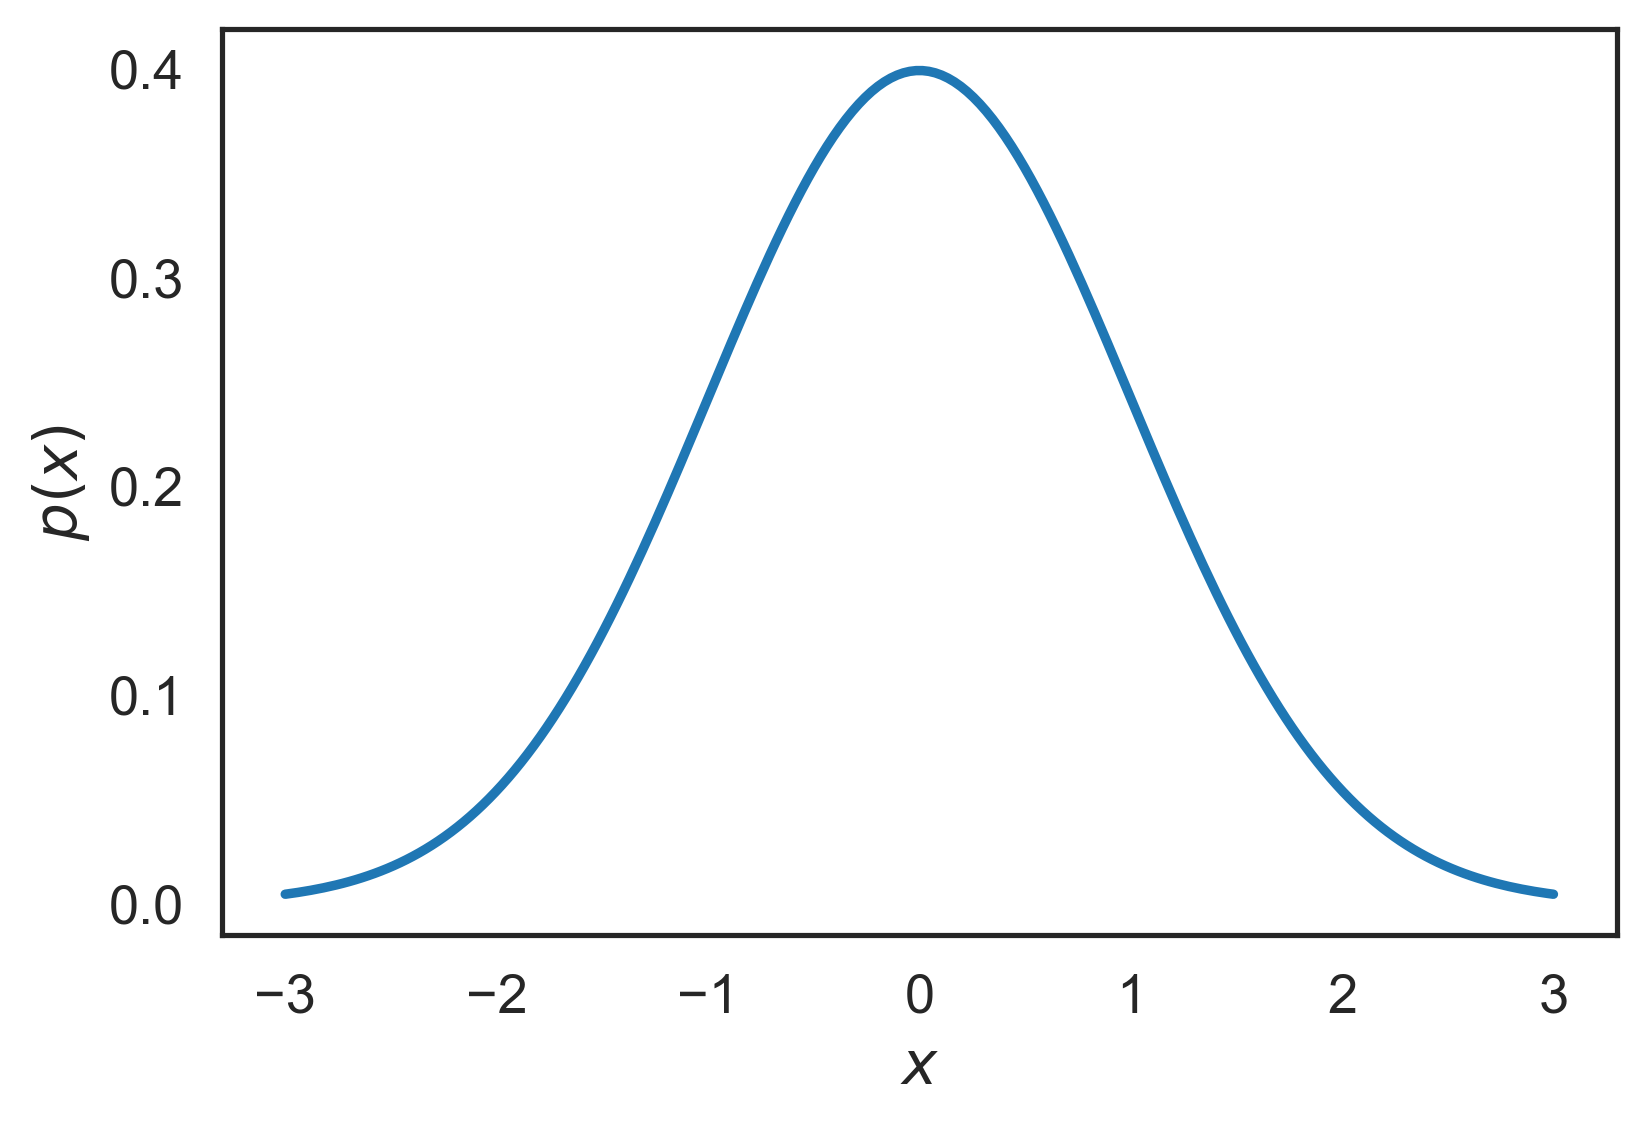

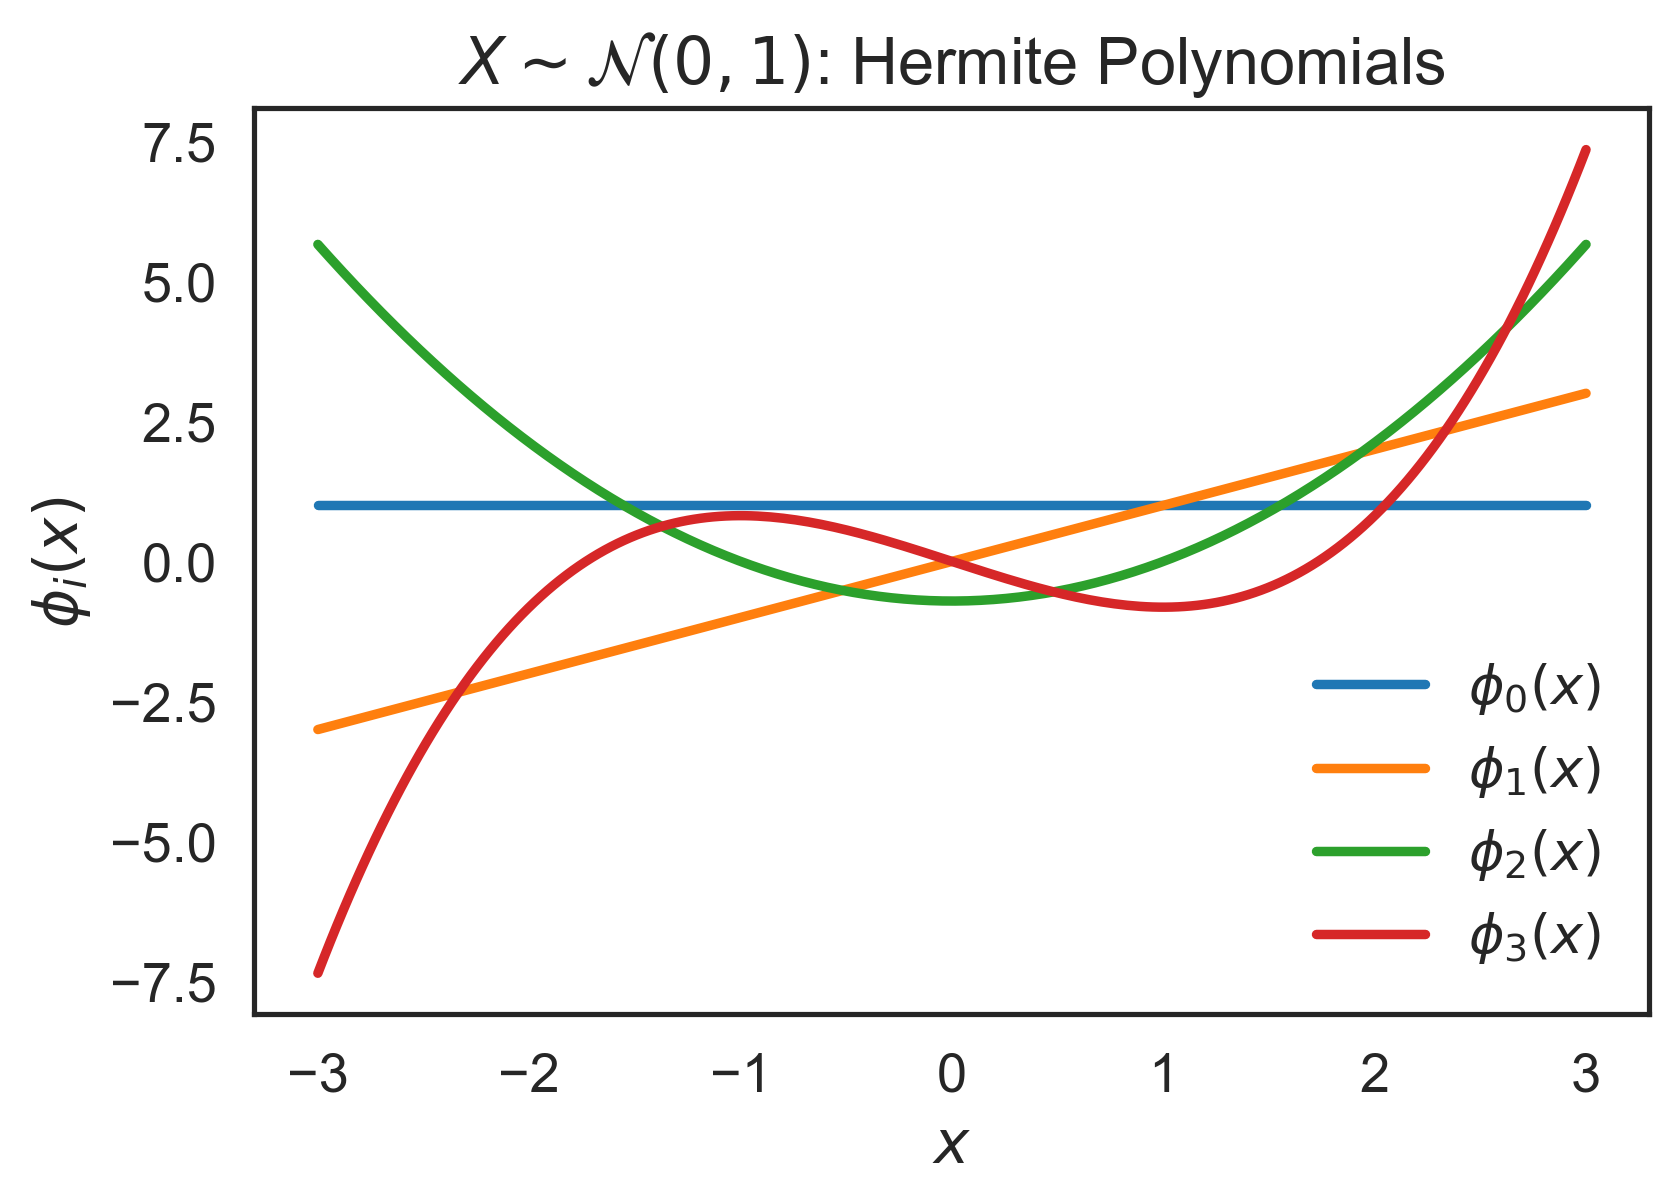

In [7]:
# The random variable you wish to consider
X = st.norm()
# The maximum polynomial degree you want
degree = 3
# Construct the orthogonal polynomials
Phi_set = orthpol.OrthogonalPolynomial(degree, X, ncap=1000)

# Plot the probability density
fig, ax = plt.subplots()
x = np.linspace(-3, 3, 200)
ax.plot(x, X.pdf(x))
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')

# Plot them
fig, ax = plt.subplots()
# Evaluate the orhtogonal polynomials on all these x's
phi_x = Phi_set(x)    # 200 x (degree + 1)
# Plot each one of them
ax.plot(x, phi_x);
ax.set_xlabel('$x$')
ax.set_ylabel('$\phi_i(x)$')
ax.set_title('$X\sim\mathcal{N}(0,1)$: Hermite Polynomials')
plt.legend(['$\phi_{%d}(x)$' % i for i in range(0, degree + 1)], loc='best');

In [8]:
Z, v = design.sparse_grid(1, 8, 'F1') # We do not use CC because it is closed (includes -1, 1) - Fejer 1 is open
X = st.norm.ppf(0.5 * (Z + 1.))
w = v / 2
phi_q = Phi_set(X)
for i in range(phi_q.shape[1]):
    for j in range(i, phi_q.shape[1]):
        print '<%d, %d> \t= %1.3f' % (i, j, np.sum(w * phi_q[:, i] * phi_q[:, j]))

<0, 0> 	= 1.000
<0, 1> 	= 0.000
<0, 2> 	= 0.000
<0, 3> 	= -0.000
<1, 1> 	= 1.000
<1, 2> 	= -0.000
<1, 3> 	= 0.000
<2, 2> 	= 1.000
<2, 3> 	= -0.000
<3, 3> 	= 1.000


### Example 2: The Exponential and the Laguerre Polynomials

Let $X\sim\mathcal{E}(1)$. The orthogonal polynomials in this case are known as the [Laguerre polynomials](https://en.wikipedia.org/wiki/Laguerre_polynomials).
They are known analytically.
The first few are:
$$
\begin{array}{ccc}
\phi_1(x) &=& 1,\\
\phi_2(x) &=& -x + 1,\\
\phi_3(x) &=& \frac{1}{2}\left(x^2 - 4x + 2\right).
\end{array}
$$

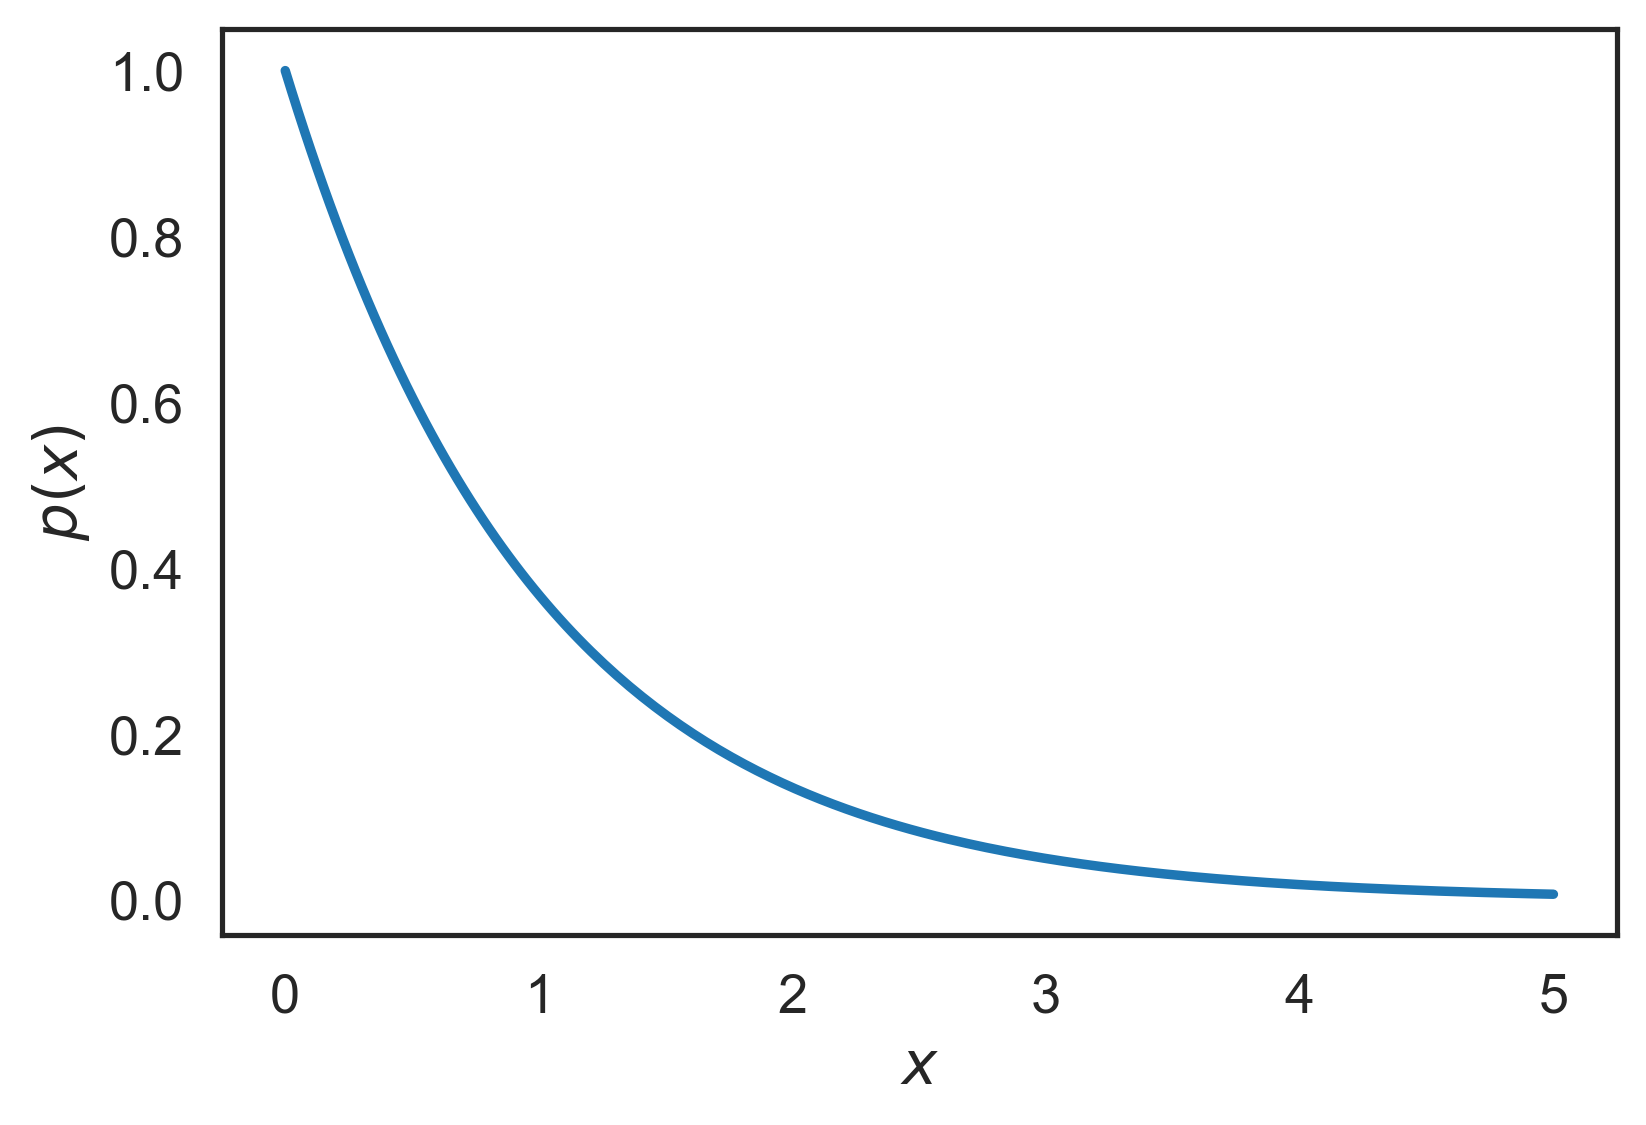

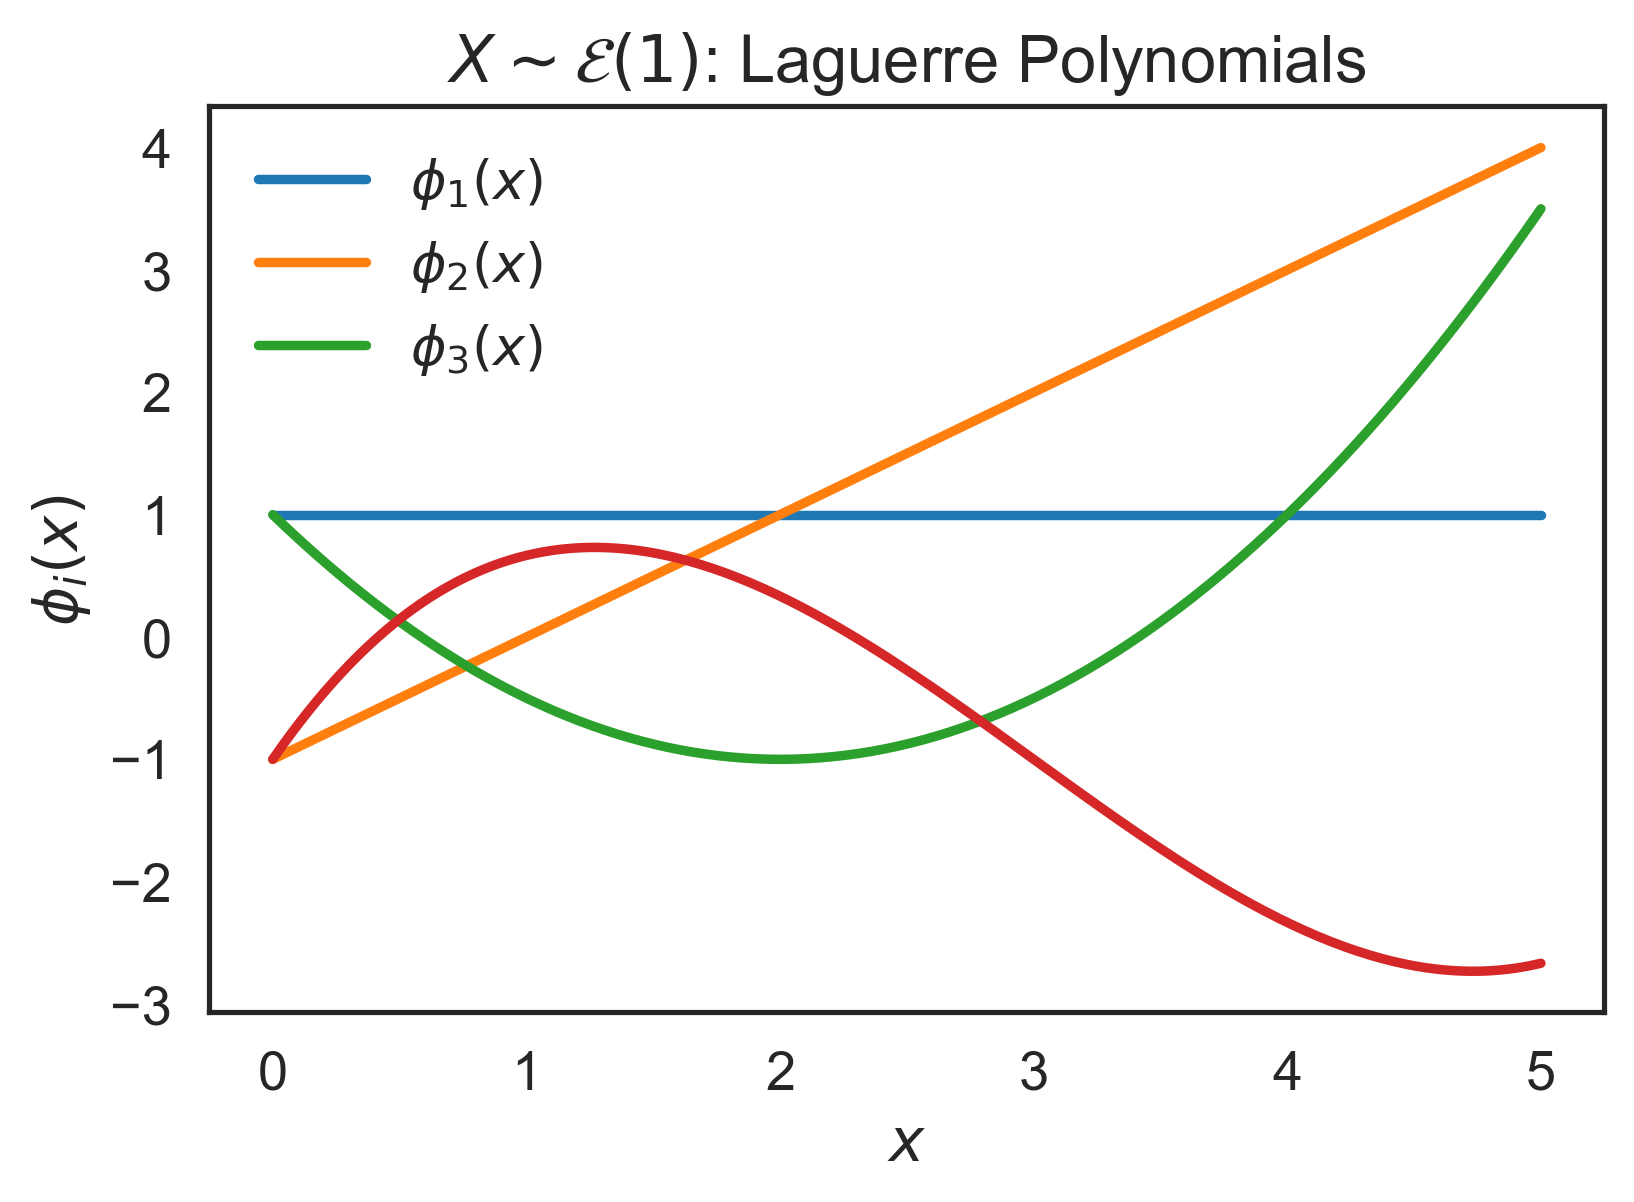

In [9]:
# The random variable you wish to consider
X = st.expon()
# The maximum polynomial degree you want
degree = 3
# Construct the orthogonal polynomials
Phi_set = orthpol.OrthogonalPolynomial(degree, X)

# Plot the probability density
fig, ax = plt.subplots()
x = np.linspace(0, 5, 200)
ax.plot(x, X.pdf(x))
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')

# Plot them
fig, ax = plt.subplots()
# Evaluate the orhtogonal polynomials on all these x's
phi_x = Phi_set(x)    # 200 x (degree + 1)
# Plot each one of them
ax.plot(x, phi_x);
ax.set_xlabel('$x$')
ax.set_ylabel('$\phi_i(x)$')
ax.set_title('$X\sim\mathcal{E}(1)$: Laguerre Polynomials')
plt.legend(['$\phi_{%d}(x)$' % i for i in range(1, degree + 1)], loc='best');

In [10]:
Z, v = design.sparse_grid(1, 9, 'F1') # Again F1 isntead of CC
w = v / 2.
X = st.expon.ppf(0.5 * (Z + 1.))
phi_q = Phi_set(X)
for i in range(phi_q.shape[1]):
    for j in range(i, phi_q.shape[1]):
        print '<%d, %d> \t= %1.3f' % (i, j, np.sum(w * phi_q[:, i] * phi_q[:, j]))

<0, 0> 	= 1.000
<0, 1> 	= 0.000
<0, 2> 	= 0.000
<0, 3> 	= -0.000
<1, 1> 	= 1.000
<1, 2> 	= -0.000
<1, 3> 	= -0.000
<2, 2> 	= 1.000
<2, 3> 	= -0.001
<3, 3> 	= 0.991


## Example 4: We can do it for any probability density

We can construct orthonormal for any random variable $X$.
Let's do it for a mixture of Gaussians:
$$
p(x) = \pi_1 \mathcal{N}(x|\mu_1,\sigma_1^2) + \pi_2\mathcal{N}(x|\mu_2,\sigma_2^2),
$$
for $\pi_1 + \pi_2 = 1$.

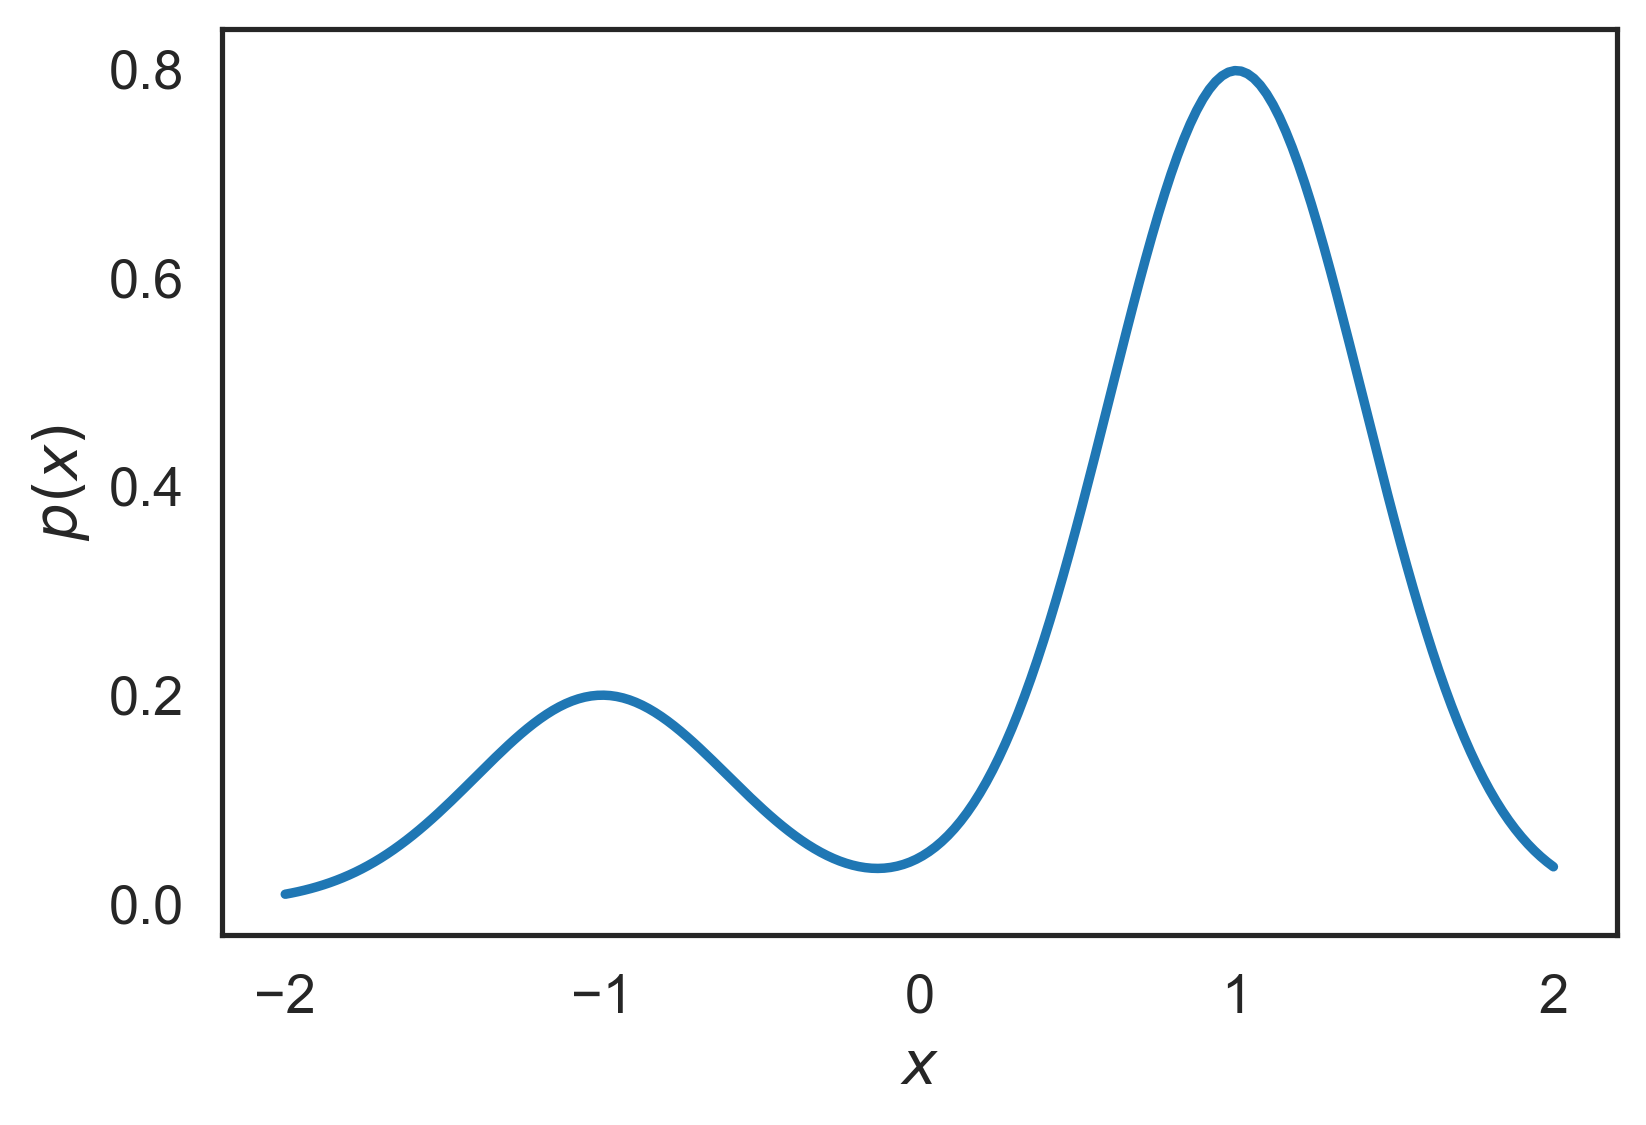

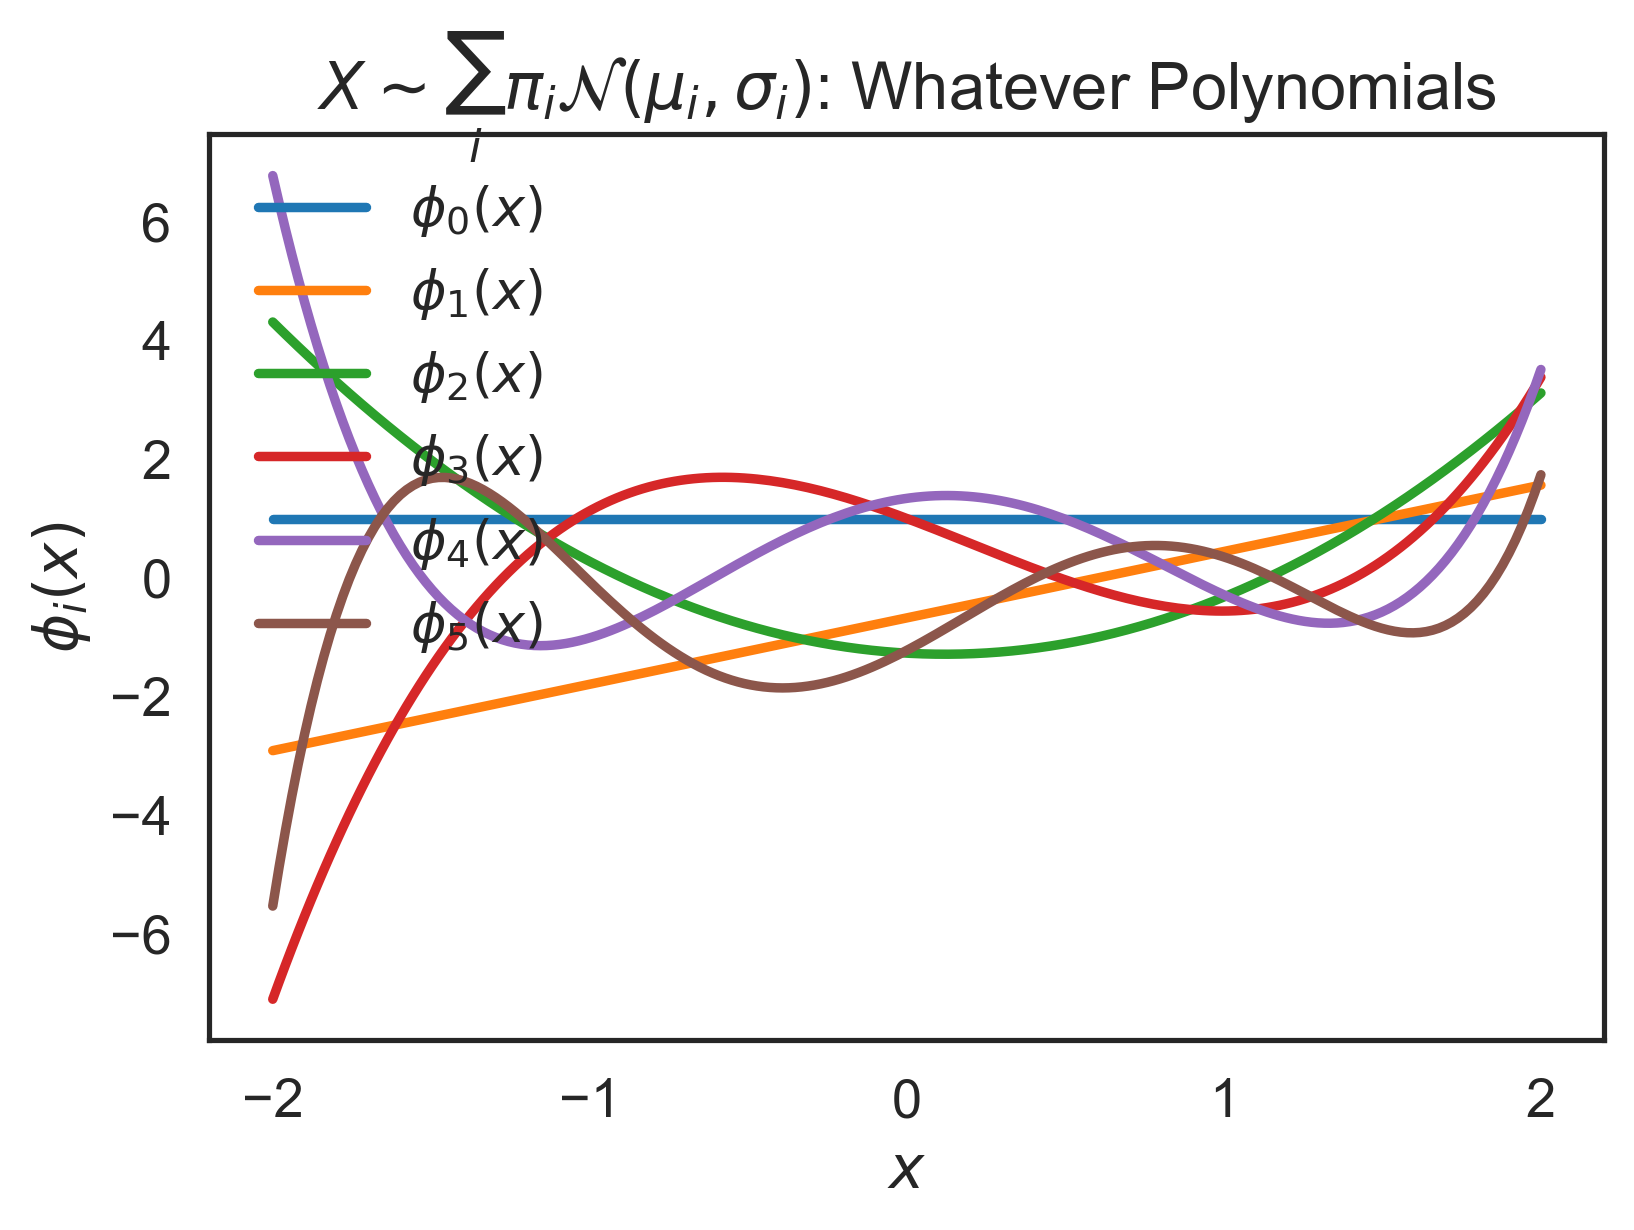

In [11]:
# The random variable you wish to consider
X1 = st.norm(loc=-1, scale=0.4)
pi_1 = 0.2
X2 = st.norm(loc=+1, scale=0.4)
pi_2 = 0.8

p = lambda x: pi_1 * X1.pdf(x) + pi_2 * X2.pdf(x)

class MGRV(st.rv_continuous):
    
    def _pdf(self, x):
        return p(x)

mgrv = MGRV()
    
# The maximum polynomial degree you want
degree = 5
# Construct the orthogonal polynomials
Phi_set = orthpol.OrthogonalPolynomial(degree, wf=mgrv.pdf, left=-np.inf, right=np.inf, ncap=5000)
Phi_set.normalize()

# Plot the probability density
fig, ax = plt.subplots()
x = np.linspace(-2, 2, 200)
ax.plot(x, mgrv.pdf(x))
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')

# Plot them
fig, ax = plt.subplots()
# Evaluate the orhtogonal polynomials on all these x's
phi_x = Phi_set(x)    # 200 x (degree + 1)
# Plot each one of them
ax.plot(x, phi_x);
ax.set_xlabel('$x$')
ax.set_ylabel('$\phi_i(x)$')
ax.set_title('$X\sim\sum_i\pi_i\mathcal{N}(\mu_i,\sigma_i)$: Whatever Polynomials')
plt.legend(['$\phi_{%d}(x)$' % i for i in range(0, degree + 1)], loc='best');

<0, 0> 	= 1.000
<0, 1> 	= -0.000
<0, 2> 	= -0.000
<0, 3> 	= 0.000
<0, 4> 	= 0.000
<0, 5> 	= -0.001
<1, 1> 	= 1.000
<1, 2> 	= 0.000
<1, 3> 	= -0.000
<1, 4> 	= -0.001
<1, 5> 	= -0.000
<2, 2> 	= 1.000
<2, 3> 	= -0.001
<2, 4> 	= -0.002
<2, 5> 	= 0.002
<3, 3> 	= 0.999
<3, 4> 	= 0.002
<3, 5> 	= -0.013
<4, 4> 	= 0.988
<4, 5> 	= 0.004
<5, 5> 	= 0.942


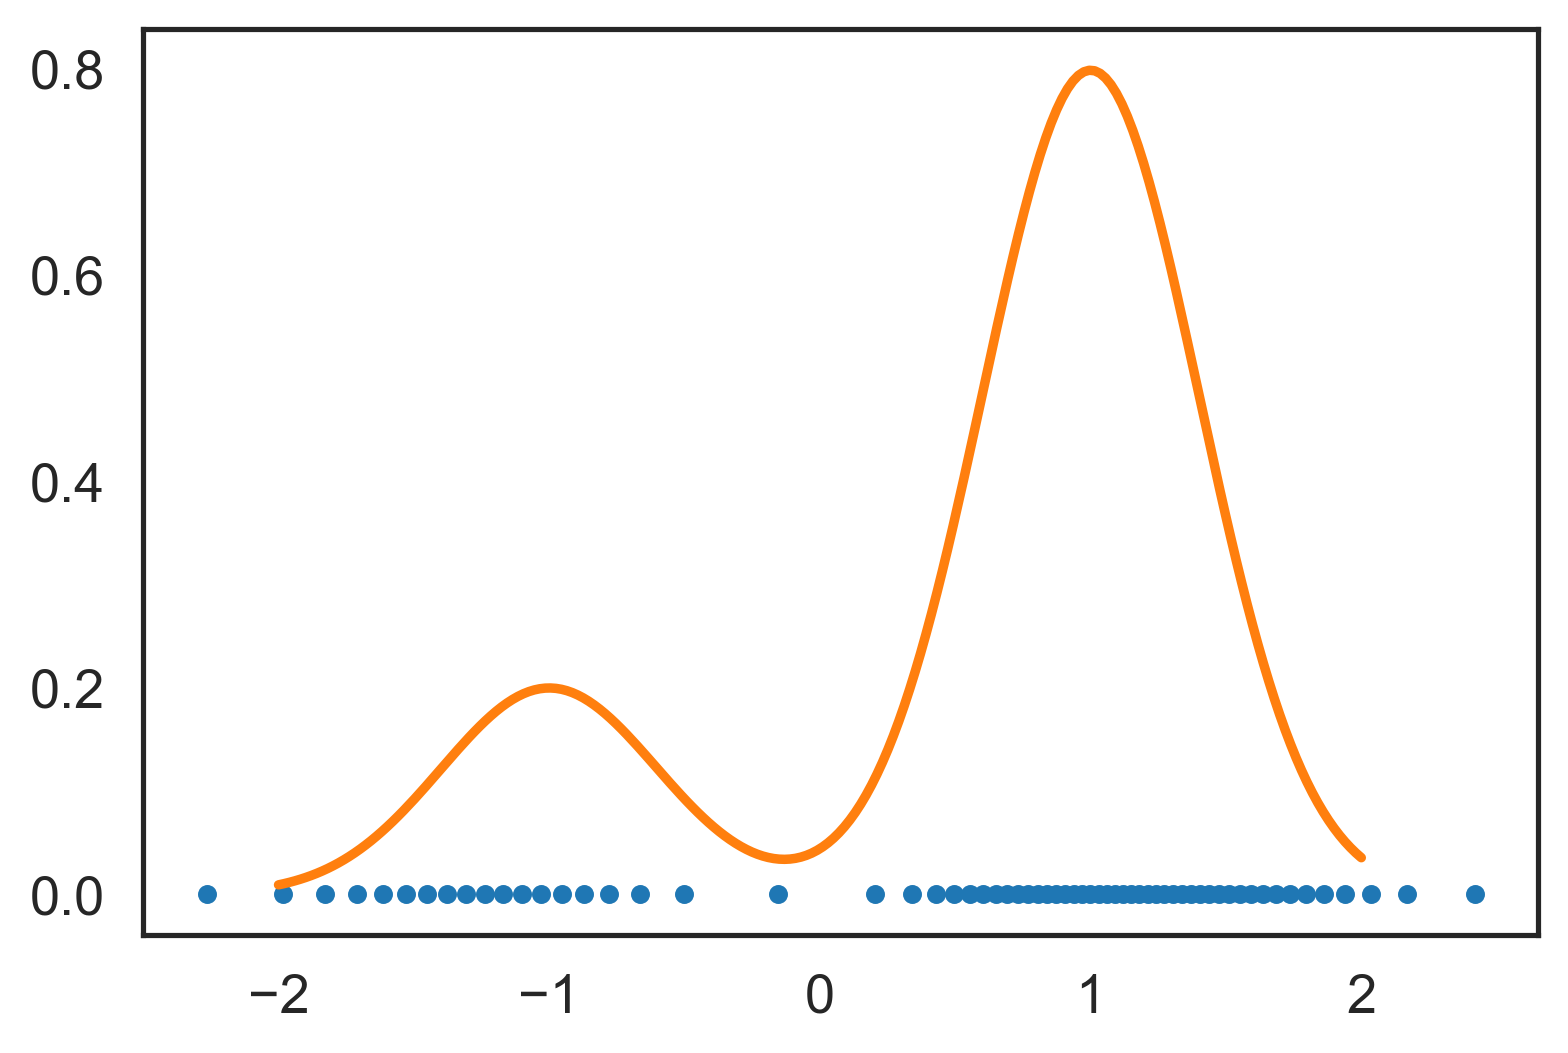

In [12]:
# For this one we need a quadrature rule in (-infty, +infty) with w(x) = the pdf of the mixture
# Let's use a rule in (-1, 1) (the rule is open if the boundaries are not included) and transform it to (-infty, infty)
Z, v = design.sparse_grid(1, 5, 'F1') # Fejer 2, open, fully nested, w(x) = 1 and x in (-1, 1)
X = mgrv.ppf(0.5 * (Z + 1))
w = v / 2.

#X = st.norm.ppf(0.5 * (Z + 1))
#w = v / (2. * st.norm.pdf(X)) * p(X)
plt.plot(X, np.zeros(X.shape[0], ), '.')
plt.plot(x, mgrv.pdf(x))

#help(st.norm.ppf)
#w = w / 2.  # We need to normalize the weights
phi_q = Phi_set(X)
for i in range(phi_q.shape[1]):
    for j in range(i, phi_q.shape[1]):
        print '<%d, %d> \t= %1.3f' % (i, j, np.sum(w * phi_q[:, i] * phi_q[:, j]))

### More 1D Quadrature Rules

There are many more quadrature rules with various properties.
Some of the ones you can use from ``py-design`` are described [here](http://people.sc.fsu.edu/~jburkardt/f_src/sparse_grid_mixed_dataset/sparse_grid_mixed_dataset.html):

In [13]:
help(design.sparse_grid)

Help on function sparse_grid in module design:

sparse_grid(num_dim, max_level, rule='CC')
    Compute a Sparse Grid.
    
    Parameters
    ----------
    num_dim     :   int
                    Number of dimensions.
    max_level   :   int
                    The maximum level of the sparse grid.
    rule        :   str
                    The quadrature rule. The default is "CC". Choose from:
    
                        1. "CC", Clenshaw Curtis Closed Fully Nested rule.
                        2. "F1", Fejer 1 Open Fully Nested rule.
                        3. "F2", Fejer 2 Open Fully Nested rule.
                        4. "GP", Gauss Patterson Open Fully Nested rule.
                        5. "GL", Gauss Legendre Open Weakly Nested rule.
                        6. "GH", Gauss Hermite Open Weakly Nested rule.
                        7. "LG", Gauss Laguerre Open Non Nested rule.
    
    Returns
    -------
    grid_point  :   (num_point, num_dim) ndarray
                    The 

## Quadrature Rules in High-Dimensions


### Tensor Products of Quadrature Rules
The simplest approach to create high-dimensional quadrature rules is to take the tensor product of 1D ones.
For example, suppose you have a quadrature rule in 1D:
$$
Q^{(1)}(f) = \sum_{k=1}^n w_k f(x_k).
$$
The *tensor* product of $Q^{(1)}$ with itself is the 2D quadrature rule:
$$
Q^{(2)} = Q^{(1)}\otimes Q^{(1)}
$$
defined by:
$$
Q^{(2)}(f) = \left(Q^{(1)}\otimes Q^{(1)}\right)(f) = \sum_{i=1}^n\sum_{j=1}^n w_i w_j f(x_i, x_j).
$$
The tensor product can be generalized between any two quadrature rules in arbitrary dimensions.

**Note:** The number of nodes in the tensor product of two quadrature rules grows exponential with the dimensionality (*curse of dimensionality*).

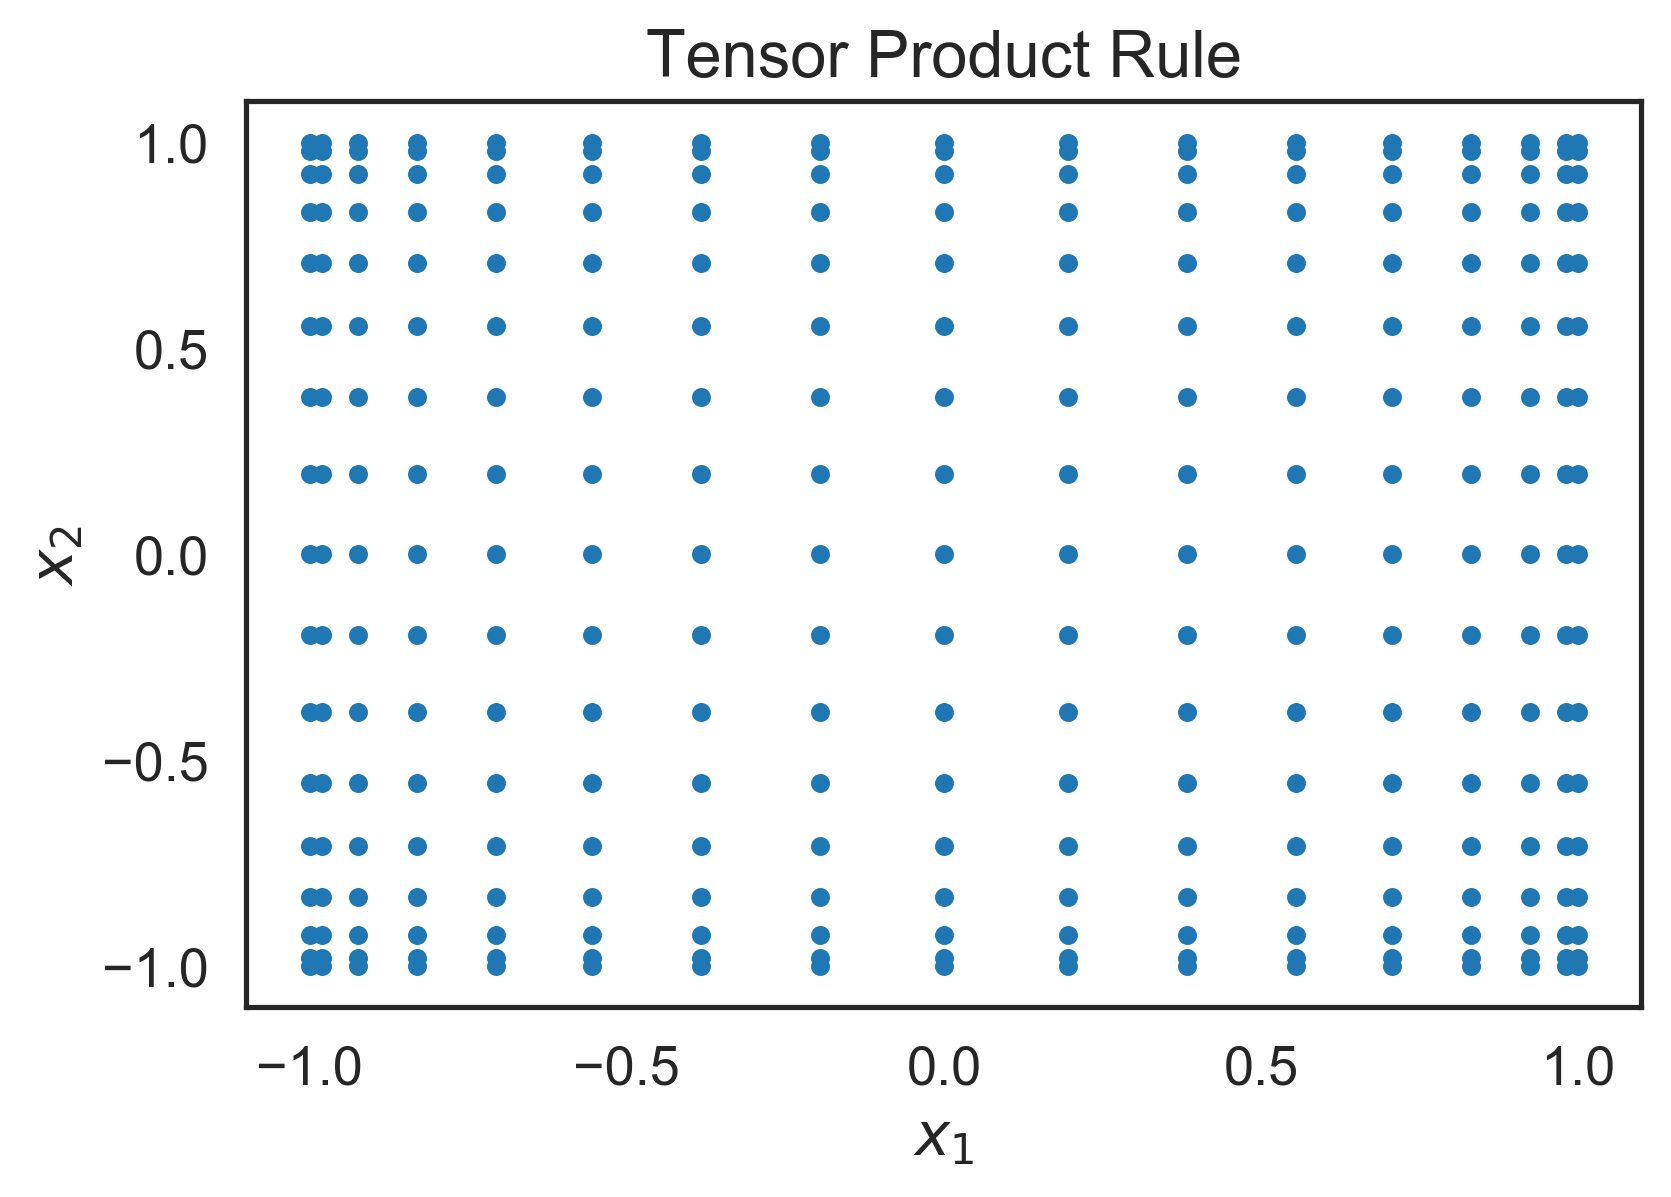

In [14]:
from itertools import izip

level = 4
Z, v = design.sparse_grid(1, level, 'CC')

# Make the tensor rule
nq = Z.shape[0]
Z21, Z22 = np.meshgrid(Z, Z)
Z2 = np.hstack([Z21.flatten()[:, None], Z22.flatten()[:, None]])

# Plot it
fig, ax = plt.subplots()
ax.plot(Z2[:, 0], Z2[:, 1], '.')
ax.set_title('Tensor Product Rule')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

### Sparse Grid Quadrature

You can build a sparse grid (SG) quadrature out of any 1D quadrature rule $Q_\ell^{(1)}$ of level $\ell$.
The only restriction is that $Q_\ell^{(1)}$ must be nested, in the sense that all that nodes that are in $Q_{\ell}^{(1)}$ must be included in $Q_{\ell+1}^{(1)}$.
The whole point is to get a rule in which the number of nodes does not grow as fast as in a tensor product.

The construction of high-dimensional sparse grids is given by the *Smolyak quadrature formula*:
$$
Q_\ell^{(d)}(f) := \left(\sum_{i=1}^\ell\left(Q_i^{(1)} - Q_{i-1}^{(1)}\right)\otimes Q_{\ell-i+1}^{(d-1)}\right)(f).
$$
Understanding this formula is beyond what we want to do.
Let's just look at how sparse grids look like.

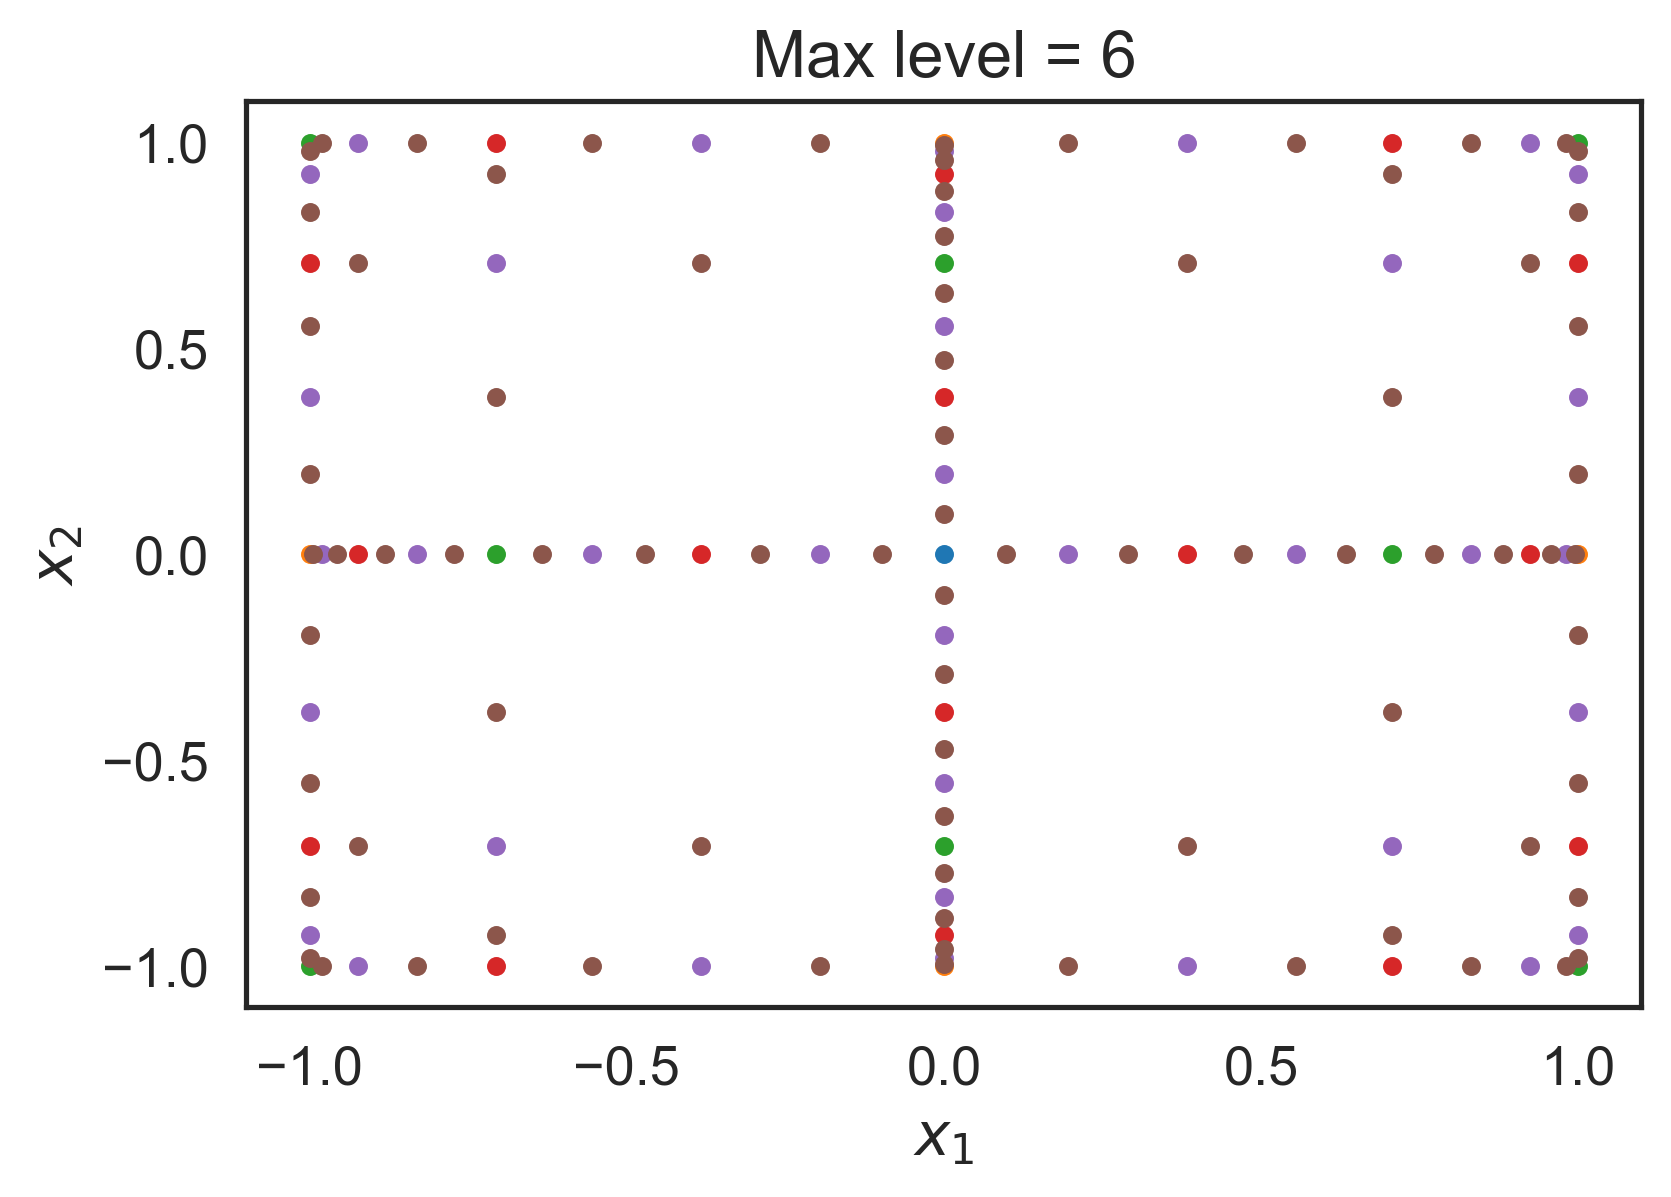

In [15]:
fig, ax = plt.subplots()
level = 6
count = 0
for i in range(level):
    Z, v = design.sparse_grid(2, i, 'CC')
    ax.plot(Z[count:, 0], Z[count:, 1], '.', color=sns.color_palette()[i], label='$L=%d$' % (i + 1))
    count = Z.shape[0]
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Max level = %d' % level);
#plt.legend(loc='best');

Sparse grids grow much slower than tensor products. See below how the number of nodes grows as a function of the space dimensionality.

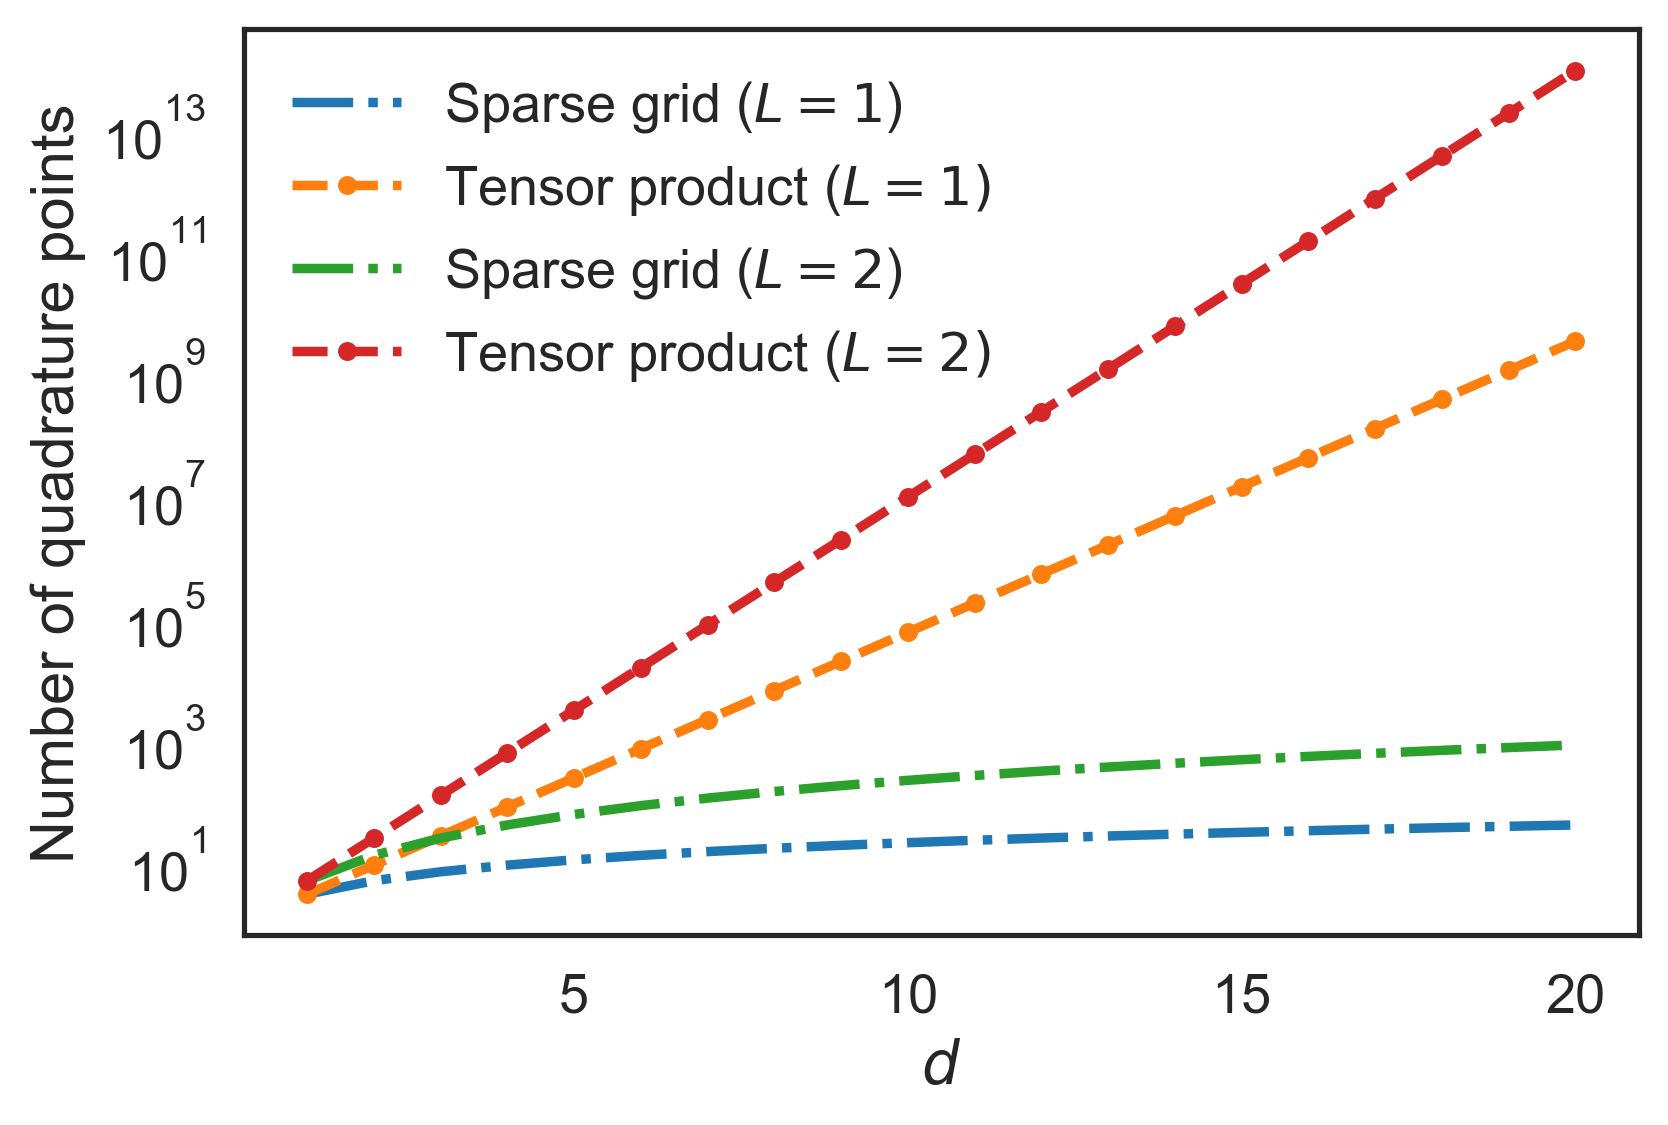

In [16]:
fig, ax = plt.subplots()
max_dim = 20
for level in range(1, 3):
    Z1, _ = design.sparse_grid(1, level, 'CC')
    sparse_grid_num_nodes = []
    tensor_num_nodes = []
    for d in range(1, max_dim + 1):
        Z, _ = design.sparse_grid(d, level, 'CC')
        sparse_grid_num_nodes.append(Z.shape[0])
        tensor_num_nodes.append(Z1.shape[0] ** d)
    ax.semilogy(range(1, max_dim + 1), sparse_grid_num_nodes, '-.', label='Sparse grid ($L=%d$)' % level)
    ax.semilogy(range(1, max_dim + 1), tensor_num_nodes, '--.', label='Tensor product ($L=%d)$' % level)
ax.set_xlabel('$d$')
ax.set_ylabel('Number of quadrature points')
plt.legend(loc='best');

## Example 5: Multidimensional Orthogonal Polynomials

Let's construct orthogonal polynomials for a random vector:
$$
X = (X_1,X_2),
$$
where
$$
X_1\sim\mathcal{U}(-1,1),
$$
and
$$
X_2\sim\mathcal{U}(-1, 1).
$$

In [17]:
X1 = st.uniform(loc=-1, scale=2)
X2 = st.uniform(loc=-1, scale=2)
X = (X1, X2)
dim = len(X)

# The maximum polynomial degree you want
degree = 4
# Construct the orthogonal polynomials - See documentation for more ways to do create
# multi-dimensional polynomials
Phi_set = orthpol.ProductBasis(X, degree=degree)

Z, v = design.sparse_grid(dim, 4, 'CC') # Gauss-Hermite which uses w(x) = e^{-x^T x} - need to scale:
X = Z
w = v / (2 ** dim)

phi_q = Phi_set(Z)
for i in range(phi_q.shape[1]):
    for j in range(i, phi_q.shape[1]):
        print '<%d, %d>\t= %1.2f' % (i, j, np.sum(w * phi_q[:, i] * phi_q[:, j]))

<0, 0>	= 1.00
<0, 1>	= 0.00
<0, 2>	= 0.00
<0, 3>	= -0.00
<0, 4>	= 0.00
<0, 5>	= -0.00
<0, 6>	= 0.00
<0, 7>	= 0.00
<0, 8>	= 0.00
<0, 9>	= 0.00
<0, 10>	= 0.00
<0, 11>	= -0.00
<0, 12>	= 0.00
<0, 13>	= -0.00
<0, 14>	= 0.00
<1, 1>	= 1.00
<1, 2>	= 0.00
<1, 3>	= 0.00
<1, 4>	= 0.00
<1, 5>	= 0.00
<1, 6>	= 0.00
<1, 7>	= -0.00
<1, 8>	= -0.00
<1, 9>	= -0.00
<1, 10>	= 0.00
<1, 11>	= 0.00
<1, 12>	= -0.00
<1, 13>	= 0.00
<1, 14>	= -0.00
<2, 2>	= 1.00
<2, 3>	= 0.00
<2, 4>	= 0.00
<2, 5>	= 0.00
<2, 6>	= -0.00
<2, 7>	= -0.00
<2, 8>	= 0.00
<2, 9>	= 0.00
<2, 10>	= -0.00
<2, 11>	= 0.00
<2, 12>	= 0.00
<2, 13>	= -0.00
<2, 14>	= 0.00
<3, 3>	= 1.00
<3, 4>	= 0.00
<3, 5>	= 0.00
<3, 6>	= 0.00
<3, 7>	= 0.00
<3, 8>	= 0.00
<3, 9>	= -0.00
<3, 10>	= 0.00
<3, 11>	= -0.00
<3, 12>	= -0.00
<3, 13>	= 0.00
<3, 14>	= -0.00
<4, 4>	= 1.00
<4, 5>	= -0.00
<4, 6>	= -0.00
<4, 7>	= 0.00
<4, 8>	= 0.00
<4, 9>	= -0.00
<4, 10>	= 0.00
<4, 11>	= -0.00
<4, 12>	= -0.00
<4, 13>	= -0.00
<4, 14>	= -0.00
<5, 5>	= 1.00
<5, 6>	= -0.00
<5, 7>	= 0.0

## Example 6: Multidimensional Orthogonal Polynomials

Let's construct orthogonal polynomials for a random vector:
$$
X = (X_1,X_2),
$$
where
$$
X_1\sim\mathcal{N}(0,1),
$$
and
$$
X_2\sim\mathcal{N}(0, 1).
$$

In [18]:
X1 = st.norm()
X2 = st.norm()
X = (X1, X2)
dim = len(X)

# The maximum polynomial degree you want
degree = 4
# Construct the orthogonal polynomials - See documentation for more ways to do create
# multi-dimensional polynomials
Phi_set = orthpol.ProductBasis(X, degree=degree)

Z, v = design.sparse_grid(2, 5, 'GH') # Gauss-Hermite which uses w(x) = e^{-x^T x} - need to scale:
X = Z * np.sqrt(2.)
w = v / np.sqrt(np.pi ** dim)

phi_q = Phi_set(X)
for i in range(phi_q.shape[1]):
    for j in range(i, phi_q.shape[1]):
        print '<%d, %d>\t= %1.2f' % (i, j, np.sum(w * phi_q[:, i] * phi_q[:, j]))

<0, 0>	= 1.00
<0, 1>	= 0.00
<0, 2>	= -0.00
<0, 3>	= -0.00
<0, 4>	= 0.00
<0, 5>	= -0.00
<0, 6>	= -0.00
<0, 7>	= 0.00
<0, 8>	= 0.00
<0, 9>	= -0.00
<0, 10>	= 0.00
<0, 11>	= 0.00
<0, 12>	= 0.00
<0, 13>	= 0.00
<0, 14>	= 0.00
<1, 1>	= 1.00
<1, 2>	= 0.00
<1, 3>	= -0.00
<1, 4>	= 0.00
<1, 5>	= 0.00
<1, 6>	= 0.00
<1, 7>	= 0.00
<1, 8>	= -0.00
<1, 9>	= 0.00
<1, 10>	= -0.00
<1, 11>	= -0.00
<1, 12>	= 0.00
<1, 13>	= 0.00
<1, 14>	= -0.00
<2, 2>	= 1.00
<2, 3>	= 0.00
<2, 4>	= 0.00
<2, 5>	= -0.00
<2, 6>	= 0.00
<2, 7>	= -0.00
<2, 8>	= -0.00
<2, 9>	= 0.00
<2, 10>	= -0.00
<2, 11>	= 0.00
<2, 12>	= 0.00
<2, 13>	= -0.00
<2, 14>	= 0.00
<3, 3>	= 1.00
<3, 4>	= -0.00
<3, 5>	= 0.00
<3, 6>	= -0.00
<3, 7>	= 0.00
<3, 8>	= 0.00
<3, 9>	= 0.00
<3, 10>	= 0.00
<3, 11>	= 0.00
<3, 12>	= -0.00
<3, 13>	= -0.00
<3, 14>	= -0.00
<4, 4>	= 1.00
<4, 5>	= -0.00
<4, 6>	= -0.00
<4, 7>	= 0.00
<4, 8>	= 0.00
<4, 9>	= -0.00
<4, 10>	= 0.00
<4, 11>	= 0.00
<4, 12>	= -0.00
<4, 13>	= 0.00
<4, 14>	= -0.00
<5, 5>	= 1.00
<5, 6>	= 0.00
<5, 7>	= 0.0